# Описание задачи и план работы

В процессе страхования у страховой компании имеется слишком мало точек соприкосновения с клиентами. AutoInland (страховая компания в Западной Африке, специализирующаяся на автостраховании) должна учитывать каждую точку контакта; одна из самых ценных из них - подача и урегулирование страховых исков.

AutoInland считает, что для достижения более высоких стандартов уровня обслуживания им необходимо предвидеть будущие потребности с точки зрения объема запросов на возмещение убытков. Это позволит им лучше управлять своими ресурсами, сохраняя при этом положительный опыт клиентов и высокий уровень удовлетворенности.

Цель этой работы - разработать прогностическую модель, которая определяет, подаст ли клиент заявку на страхование транспортного средства в ближайшие три месяца. Это решение поможет оптимизировать финансовое планирование в AutoInland и позволит им лучше обслуживать своих клиентов, понимая, какие клиенты могут подать иск.

Данная работа состоит из следующих частей:

Часть 1. *Введение*
- Загрузка библиотек
- Описание функций
- Загрузка и предварительный осмотр данных

Часть 2. *Построение базовой модели*
- Предобработка для построения моделей
- Basic DecisionTree
- Basic Catboost

Часть 3. *Анализ данных*

Часть 4. *Заполнение пустых значений*

Часть 5. *Генерация признаков*

Часть 6. *Подготовка данных для построения модели*

Часть 7. *Эксперимент 1*
- обработка данных: KNN Imputer + mean target enc.
- CatBoostClassifier
- DecisionTree
- RandomForest
- LGBMClassifier
- XGBClassifier

Часть 8. *Эксперимент 2*
- обработка данных: KNN Imputer + get_dummies
- LGBMClassifier

Часть 9. *Эксперимент 3*
- обработка данных: MODE + mean target enc
- LGBMClassifier

Часть 10. *Эксперимент 4*
- обработка данных: MODE + get_dummies
- CatBoostClassifier
- DecisionTree
- RandomForest
- LGBMClassifier
- XGBClassifier

Часть 11. *Восстановление лучшего результата*

Часть 12. *Кросс валидация*

Часть 13. *Стороннее решение*

# ВВЕДЕНИЕ

## 1. Загрузка билиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msn
from datetime import datetime
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')
import graphviz

In [3]:
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## 2. Функции

In [4]:
def bar_vc(data, attribute, figsize=(12, 8), title_size=12, rotation=0):
    
    """Данная функция вернет столбчатую диаграмму. Главное указать данные и признак"""
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(np.arange(0, len(data[attribute].value_counts().index)), data[attribute].value_counts().values)
    
    ax.set_title(f'Распределение значений признака {attribute}', size=title_size)
    
    plt.xticks(range(len(data[attribute].value_counts().index)), list(data[attribute].value_counts().index),
              rotation=rotation)
    plt.show()

In [5]:
def hist_vc(data, attribute, figsize=(12, 8), title_size=12):
    
    """Данная функция вернет гистограмму. Главное указать данные и признак"""
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.hist(data[attribute], bins=len(data[attribute].unique()))
    
    ax.set_title(f'Распределение значений признака {attribute}', size=title_size)
    
    plt.show()

In [6]:
def get_description(data):

    """Данная функция вернет более расширенное описание датафрейма, чем .info()"""
    
    first_value = list(data.iloc[0].values)
    second_value = list(data.iloc[1].values)
    third_value = list(data.iloc[2].values)
    
    dtype_list = []     
    nans = []
    
    for elem in data.columns:
        dtype_list.append(data.loc[:, elem].dtype)
        nans.append(sum(data.loc[:, elem].isnull()))
    
    
    d = {'first_value': first_value,
        'second_value': second_value,
        'third_value': third_value,
        'dtype': dtype_list,
        'nans': nans}
    
    df = pd.DataFrame(data=d, index=data.columns)
    

    return df

In [7]:
def get_to_target_description(data, attribute, rotation=50):
    
    """Данная функция покажет количество каждого имеющегося в признаке значения по отношению к целевой переменной.
    Mean Target Encoding description"""
    
    df = data.loc[:, [attribute, 'target']]
    values = list(df[attribute].value_counts().index)
    elems_mean = []
    result = {}
    
    for elem in values:
        elems_mean.append(round(df[df[attribute]==elem]['target'].mean(), 5))
        result[elem] = round(df[df[attribute]==elem]['target'].mean(), 5)
    
    
    for i, j in result.items():
        print(f'распределение {i} к целевой перменной', j)
    
    plt.figure(figsize=(15, 10))
    sns.barplot(x=attribute, y='target', data=data)
    plt.xticks(rotation=rotation)
    plt.show();

In [8]:
def get_mean_target_encoding(data, attribute):
    
    """Данная функция произведет кодировку признаков в mean_target"""
    
    df = data.loc[:, [attribute, 'target']]
    values = list(df[attribute].value_counts().index)
    elems_mean = []
    result = {}
    
    for elem in values:
        elems_mean.append(round(df[df[attribute]==elem]['target'].mean(), 5))
        result[elem] = round(df[df[attribute]==elem]['target'].mean(), 5)
        
    data.replace(result, inplace=True)
    
    return data
    

In [9]:
def change_gender(x):
    
    """Данная функция изменит название пола, очистив признак от лишних данных"""
    
    if x == 'Male' or x =='Female':
        return x
    return 'Other'

In [10]:
def car_type_mapper(x):
    
    """Данная функция произведет чистку призхнака car_type"""
    
    if x in ['Saloon', 'Sedan', 'JEEP', 'CAMRY' 'CAR HIRE', 'Shape Of Vehicle Chasis', 'Wagon', 'Station 4 Wheel', 'Mini Van','Pick Up']:
        return 'Sedan'
    elif x in ['Truck', 'Pick Up > 3 Tons', 'Tipper Truck']:
        return 'Truck'
    elif x in ['Bus','Mini Bus','Van']:
        return 'Bus'
    

In [11]:
def subject_car_mapper(x):
    
    """Данная функция произведет чистку призхнака subject_car"""
    
    if x in ['As Attached', 'Motorcycle', 'ZOYTE', 'Seat', 'FOTON', 'Black', 'Ashok Leyland', 'Geely','Caddillac','Raston',
             'MG','BRILLIANCE','Buik','COMMANDER','Bajaj','Datsun','.']:
        return 'other'
    else: 
        return x


In [12]:
def detect_outlier(data):
    
    """Данная функция определит имеющиеся в признаке статистические аномалии"""
    
    outliers=[]
    
    
    threshold=3
    mean = np.mean(data)
    std =np.std(data)
    
    
    for y in data_1:
        z_score= (y - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
        
    
    return outliers

In [13]:
def get_outliers(data, attribute):
    
    """Данная функция покажет имеющиеся в признаке статистические аномалии"""
    
    data.loc[:, attribute].dropna(inplace=True)
    Q1 = data.loc[:, attribute].quantile(0.25)
    Q3 = data.loc[:, attribute].quantile(0.75)
    IQR = Q3 - Q1 
    print("IQR", IQR)
    
    result = data[(data[attribute] < (Q1 - 1.5 * IQR)) | (data[attribute] > (Q3 + 1.5 * IQR))]
    result = pd.Series(result.loc[:, attribute].values).unique()
    print('\n','Uniqie Outliers')
    
    sns.boxplot(x=data[attribute])
    
    return result

In [14]:
def get_age_mark(data, age):
    
    
    """Данная функция разобьет возраст на несколько числовых категорий"""
    
    new_list = []
    
    for elem in data.loc[:, age]:
        if elem <= 20:
            elem = 0
            new_list.append(int(elem))
        elif elem > 20 or elem <= 35:
            elem = 1
            new_list.append(int(elem))
        elif elem > 35 or elem <= 48:
            elem = 2
            new_list.append(int(elem))
        elif elem > 48 or elem <= 60:
            elem = 3
            new_list.append(int(elem))
        elif elem > 60:
            elem = 4
            new_list.append(int(elem))
            
            
    return pd.Series(new_list)

In [15]:
def age_cleaner(data, age):
    
    """Данная функция очищает от выбросов значения возраста"""
    
    age_median = data[age].median()
    new_list = []
    
    for elem in data.loc[:, age]:
        if elem <= 16 or elem > 70:
            elem = age_median
            new_list.append(int(elem))
        else:
            new_list.append(int(elem))
            
    return pd.Series(new_list)

In [16]:
def get_lga_name_changer(data, attribute):
    
    """Данная функция видоизменяет числовые значения на строковые в признаки lga_name"""
    
    values = []
    for elem in df['lga_name']:
        if type(elem) != str:
            elem = 'no_value'
            values.append(elem)
        else:
            values.append(elem)
    
    return pd.Series(values)


In [17]:
def get_cleaned_cols(X):
    
    """Данная функция отчищает колонки датафрейма от повторений"""
    
    to_trash = []
    for i, elem in X.columns.value_counts().to_dict().items():
        if elem > 1:
            to_trash.append(i)
        else:
            None
            
    for elem in to_trash:
        X.drop(elem, axis=1, inplace=True)
    
    return X

## 3. Загрузка и предварительный осмотр данных

In [18]:
test = pd.read_csv(r"C:\Users\79165\Desktop\Test.csv")

In [19]:
train = pd.read_csv(r"C:\Data for Python\Diplom_sf\Insurance\Train.csv")

In [20]:
ss = pd.read_csv(r"C:\Users\79165\Desktop\SampleSubmission.csv")

In [21]:
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [23]:
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      1202 non-null   object
 1   Policy Start Date       1202 non-null   object
 2   Policy End Date         1202 non-null   object
 3   Gender                  1161 non-null   object
 4   Age                     1202 non-null   int64 
 5   First Transaction Date  1202 non-null   object
 6   No_Pol                  1202 non-null   int64 
 7   Car_Category            830 non-null    object
 8   Subject_Car_Colour      505 non-null    object
 9   Subject_Car_Make        954 non-null    object
 10  LGA_Name                546 non-null    object
 11  State                   546 non-null    object
 12  ProductName             1202 non-null   object
dtypes: int64(2), object(11)
memory usage: 122.2+ KB


- ID: номер записи
- Policy Start Date: Начало действия страхового полиса   
- Policy End Date: Конец действия страхового полиса
- Gender: Пол                  
- Age: Возраст                    
- First Transaction Date: День первой транзакции
- No_Pol: неизвестно              
- Car_Category: Категория авто            
- Subject_Car_Colour: Цвет авто 
- Subject_Car_Make: Марка авто        
- LGA_Name: Название города         
- State: Название штата                  
- ProductName: Название продукта (авто)
- target: целевая переменная

Объединение данных для полноценного анализа

In [25]:
data =  pd.concat((train, test)).reset_index(drop=True)

In [26]:
data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0


In [27]:
list(data.columns)

['ID',
 'Policy Start Date',
 'Policy End Date',
 'Gender',
 'Age',
 'First Transaction Date',
 'No_Pol',
 'Car_Category',
 'Subject_Car_Colour',
 'Subject_Car_Make',
 'LGA_Name',
 'State',
 'ProductName',
 'target']

Следует переименовать название некоторых колонок для удобства работы

In [28]:
data = data.rename(columns={'Policy Start Date': 'psd', 'Policy End Date': 'ped', 
                     'First Transaction Date': 'ftd', 'ProductName': 'product_name'})

In [29]:
cols = []
for elem in data.columns:
    cols.append(elem.lower())

data.columns = cols

Описание данных

In [30]:
get_description(data)

,first_value,second_value,third_value,dtype,nans
id,ID_0040R73,ID_0046BNK,ID_005QMC3,object,0
psd,2010-05-14,2010-11-29,2010-03-21,object,0
ped,2011-05-13,2011-11-28,2011-03-20,object,0
gender,Male,Female,Male,object,400
age,30,79,43,int64,0
ftd,2010-05-14,2010-11-29,2010-03-21,object,0
no_pol,1,1,1,int64,0
car_category,Saloon,JEEP,Saloon,object,4110
subject_car_colour,Black,Grey,Red,object,7659
subject_car_make,TOYOTA,TOYOTA,TOYOTA,object,2724


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  13281 non-null  object 
 1   psd                 13281 non-null  object 
 2   ped                 13281 non-null  object 
 3   gender              12881 non-null  object 
 4   age                 13281 non-null  int64  
 5   ftd                 13281 non-null  object 
 6   no_pol              13281 non-null  int64  
 7   car_category        9171 non-null   object 
 8   subject_car_colour  5622 non-null   object 
 9   subject_car_make    10557 non-null  object 
 10  lga_name            6149 non-null   object 
 11  state               6137 non-null   object 
 12  product_name        13281 non-null  object 
 13  target              12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
memory usage: 1.4+ MB


Рассмотрение пустых значений

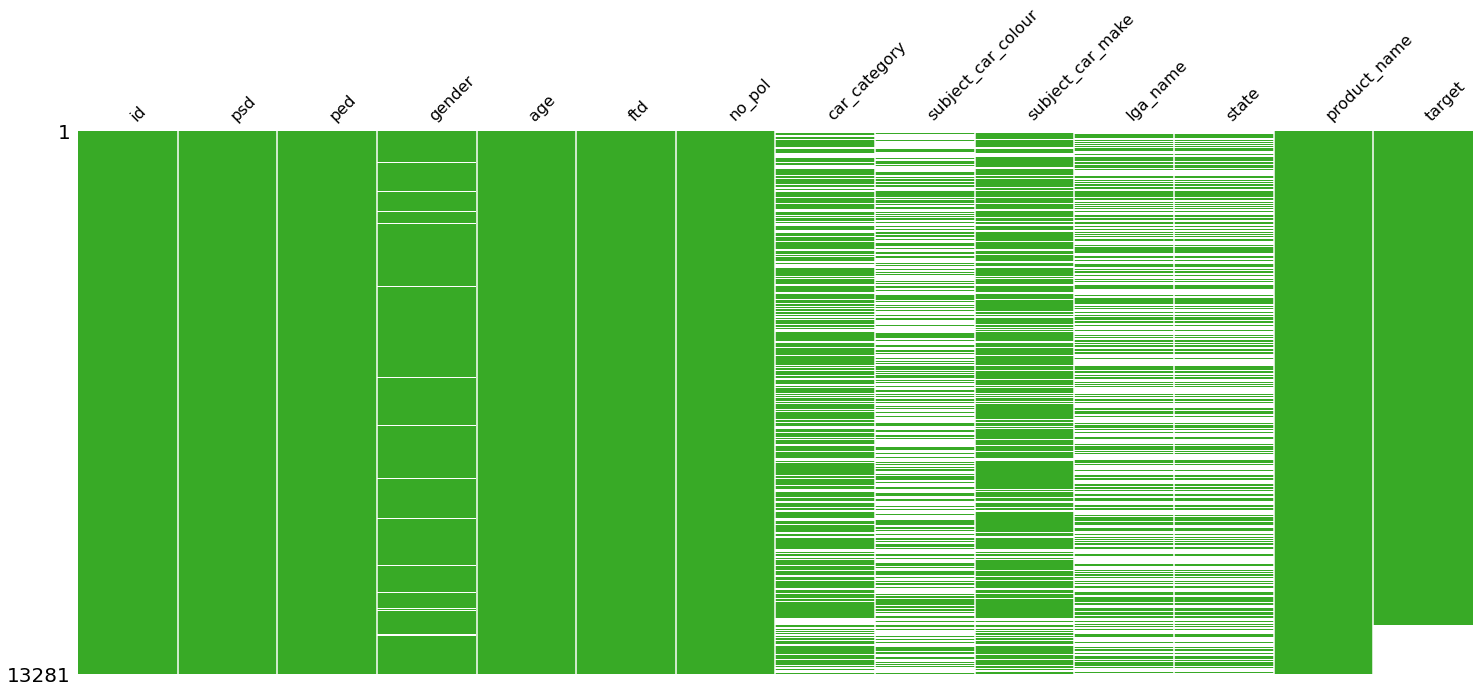

In [32]:
msn.matrix(data, color=(0.220, 0.67, 0.150), sparkline=False);

In [33]:
data.isnull().sum()

id                       0
psd                      0
ped                      0
gender                 400
age                      0
ftd                      0
no_pol                   0
car_category          4110
subject_car_colour    7659
subject_car_make      2724
lga_name              7132
state                 7144
product_name             0
target                1202
dtype: int64

In [34]:
data.isnull().sum().sum()

30371

In [35]:
sum(data.duplicated())

0

## Вывод:


Данные получены в приемлемом состоянии. 
В первой половине датасета практически не имеется пустых значений, однако присутствует критическое количество пропусков в признаках названия штата и цвета автомобиля. В дальнейшем будет произведена попытка восстановления пустых значений. 
В данных отсутсвуют дубликаты, потребовалось лишь небольшая обработка названий некоторых колонок.

___________________________

# Построение базовой модели

## Предобработка для построения моделей

Следует испробовать работу моделей пока что только на тренировочной части датасета

In [36]:
data_basic = data.iloc[train.index].copy()

In [37]:
data_basic.head()

,id,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0


На данном этапе не требуется проводить сложную обработку, достаточно заполнить пустые значением одной переменой

In [38]:
data_basic.fillna('no_value', inplace=True)

In [39]:
data_basic = data_basic.drop(['psd', 'ped','ftd','id'], axis=1)

In [40]:
cat_feat = ['gender', 'car_category', 'subject_car_colour', 'subject_car_make', 'product_name', 'lga_name', 'state']

In [41]:
data_basic.isna().sum()

gender                0
age                   0
no_pol                0
car_category          0
subject_car_colour    0
subject_car_make      0
lga_name              0
state                 0
product_name          0
target                0
dtype: int64

In [42]:
for elem in cat_feat:
    get_mean_target_encoding(data_basic, elem)

In [43]:
data_basic['target'].replace(data_basic['target'][0], 0, inplace=True)

In [44]:
sum(train['target'] == data_basic['target'])

12079

Также для базовой модели будет подготовлен датасет без признаков с наибольшим количеством пустых значений. Рассматривать датасет без пустых значений не имеет смысла, так как останется лишь 2667 наблюдений, что очень мало.

In [45]:
data_nonan = data.iloc[train.index].copy()

In [46]:
data_nonan.drop(['lga_name', 'subject_car_colour', 'state'], axis=1, inplace=True)

In [47]:
data_nonan.fillna('no_value', inplace=True)

In [48]:
data_nonan.drop(['psd', 'ped','ftd','id'], axis=1, inplace=True)

In [49]:
data_nonan.reset_index(drop=True)

,gender,age,no_pol,car_category,subject_car_make,product_name,target
0,Male,30,1,Saloon,TOYOTA,Car Classic,0.0
1,Female,79,1,JEEP,TOYOTA,Car Classic,1.0
2,Male,43,1,Saloon,TOYOTA,Car Classic,0.0
3,Male,2,1,no_value,no_value,CarSafe,0.0
4,Entity,20,3,no_value,no_value,Muuve,1.0
...,...,...,...,...,...,...,...
12074,Female,30,1,no_value,Range Rover,Car Classic,1.0
12075,Female,59,1,no_value,no_value,Car Classic,0.0
12076,Male,34,1,no_value,no_value,CarSafe,0.0
12077,no_value,120,2,no_value,TOYOTA,CVTP,0.0


In [50]:
for elem in ['gender', 'car_category', 'subject_car_make', 'product_name']:
    get_mean_target_encoding(data_nonan, elem)

In [51]:
data_nonan['target'].replace(data_basic['target'][0], 0, inplace=True)

## Basic DecisionTree

Обучение на первой обработке данных

In [52]:
X = data_basic.drop('target', axis=1)
y = data_basic['target'].replace(data_basic['target'][0], 0)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [54]:
print('Доля 1 в train sample: '+ str(round((y_train.sum()/y_train.shape[0]),3)*100 )+'%')
print('Доля 1 в test sample: '+ str(round((y_test.sum()/y_test.shape[0]),2)*100 )+'%')

Доля 1 в train sample: 12.2%
Доля 1 в test sample: 11.0%


In [55]:
tree_basic = DecisionTreeClassifier()
tree_basic.fit(X_train, y_train)

DecisionTreeClassifier()

In [56]:
print('Acuraccy в части train sample для базовой модели Tree: {}'.format(tree_basic.score(X_train, y_train)))

Acuraccy в части train sample для базовой модели Tree: 0.9461864845286143


In [57]:
y_pred = tree_basic.predict(X_test)

In [58]:
y_pred_proba = tree_basic.predict_proba(X_test)[:, 1]

In [59]:
f1_score(y_test, y_pred)

0.18784530386740333

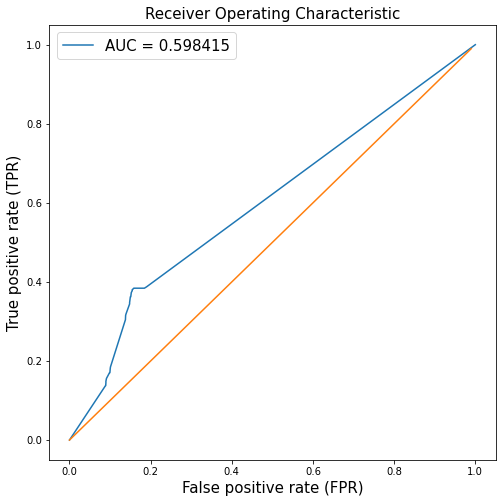

In [60]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

Обучение на второй обработке данных

In [61]:
X = data_nonan.drop('target', axis=1)
y = data_nonan['target'].apply(lambda x: int(x))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [63]:
print('Доля 1 в train sample: '+ str(round((y_train.sum()/y_train.shape[0]),3)*100 )+'%')
print('Доля 1 в test sample: '+ str(round((y_test.sum()/y_test.shape[0]),2)*100 )+'%')

Доля 1 в train sample: 12.2%
Доля 1 в test sample: 11.0%


In [64]:
tree_basic = DecisionTreeClassifier()
tree_basic.fit(X_train, y_train)

DecisionTreeClassifier()

In [65]:
print('Acuraccy в части train sample для базовой модели Tree: {}'.format(tree_basic.score(X_train, y_train)))

Acuraccy в части train sample для базовой модели Tree: 0.9138983752457829


In [66]:
y_pred = tree_basic.predict(X_test)

In [67]:
y_pred_proba = tree_basic.predict_proba(X_test)[:, 1]

In [68]:
#th = 0.2

y_pred = tree_basic.predict(X_test)
#y_proba = tree_basic.predict_proba(X_test)[:,1]
#
#y_pred[y_pred >= th] = 1
#y_pred[y_pred < th] = 0

f1_score(y_test,y_pred)

0.2102803738317757

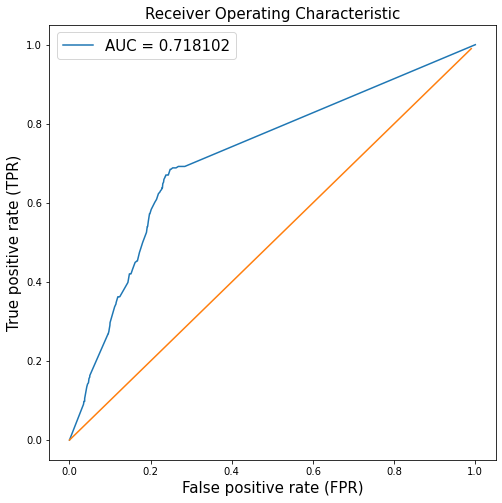

In [69]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## Basic CatBoost

In [70]:
data_basic_catboost = data.iloc[train.index].copy()

In [71]:
data_basic_catboost.drop(['id', 'psd', 'ped', 'ftd'], axis=1, inplace=True)

In [72]:
data_basic_catboost.fillna('no_value', inplace=True)

In [73]:
data_basic_catboost.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12079 entries, 0 to 12078
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              12079 non-null  object 
 1   age                 12079 non-null  int64  
 2   no_pol              12079 non-null  int64  
 3   car_category        12079 non-null  object 
 4   subject_car_colour  12079 non-null  object 
 5   subject_car_make    12079 non-null  object 
 6   lga_name            12079 non-null  object 
 7   state               12079 non-null  object 
 8   product_name        12079 non-null  object 
 9   target              12079 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 1.0+ MB


In [74]:
cat_features = [0, 3, 4, 5, 6, 7, 8]

In [75]:
X = data_basic_catboost.drop('target', axis=1)
y = data_basic_catboost['target']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [77]:
print('Доля 1 в train sample: '+ str(round((y_train.sum()/y_train.shape[0]),3)*100 )+'%')
print('Доля 1 в test sample: '+ str(round((y_test.sum()/y_test.shape[0]),2)*100 )+'%')

Доля 1 в train sample: 12.2%
Доля 1 в test sample: 11.0%


In [78]:
catboost = CatBoostClassifier(iterations=200)
catboost.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

Learning rate set to 0.111759
0:	learn: 0.5797784	test: 0.5788971	best: 0.5788971 (0)	total: 218ms	remaining: 43.4s
1:	learn: 0.5219065	test: 0.5201724	best: 0.5201724 (1)	total: 248ms	remaining: 24.6s
2:	learn: 0.4800758	test: 0.4773265	best: 0.4773265 (2)	total: 263ms	remaining: 17.3s
3:	learn: 0.4340871	test: 0.4303107	best: 0.4303107 (3)	total: 327ms	remaining: 16s
4:	learn: 0.4116176	test: 0.4070544	best: 0.4070544 (4)	total: 397ms	remaining: 15.5s
5:	learn: 0.3953465	test: 0.3900906	best: 0.3900906 (5)	total: 420ms	remaining: 13.6s
6:	learn: 0.3733364	test: 0.3674640	best: 0.3674640 (6)	total: 436ms	remaining: 12s
7:	learn: 0.3604631	test: 0.3541129	best: 0.3541129 (7)	total: 455ms	remaining: 10.9s
8:	learn: 0.3523206	test: 0.3454567	best: 0.3454567 (8)	total: 462ms	remaining: 9.81s
9:	learn: 0.3370854	test: 0.3302412	best: 0.3302412 (9)	total: 499ms	remaining: 9.47s
10:	learn: 0.3305849	test: 0.3234637	best: 0.3234637 (10)	total: 552ms	remaining: 9.48s
11:	learn: 0.3226372	test:

In [79]:
print('Acuraccy в части train sample для базовой модели CatBoost: {}'.format(catboost.score(X_train, y_train)))

Acuraccy в части train sample для базовой модели CatBoost: 0.88388699161751


In [80]:
y_pred = catboost.predict(X_test)

In [81]:
y_pred_proba = catboost.predict_proba(X_test)[:, 1]

In [82]:
f1_score(y_test, y_pred)

0.17142857142857143

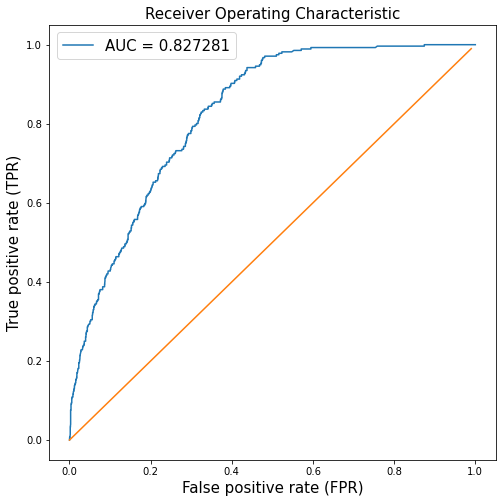

In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

In [84]:
#th = 0.2
#
#y_pred = catboost.predict(X_test)
#y_proba = catboost.predict_proba(X_test)[:,1]
#
#y_pred[y_pred >= th] = 1
#y_pred[y_pred < th] = 0
#
#f1_score(y_test,y_pred)

## Вывод:

На обоих подготовленных датасетах модели DeicisionTree и CatBoost показали себя не очень эффективно в рамках метрики f1_score. Следует провести анализх данных и их более серьезную обработку. Возможно это поможет улучшить итоговую оценку моделей.

___________________________

# Анализ данных

ID

In [85]:
data['id'].nunique()

13281

Данный признак лишь повторяет индексацию, его следует устранить

In [86]:
data.drop('id', axis=1, inplace=True)

ВременнЫе признаки. 

Следует перевести данных значения в тип datetime, чтобы можно было извлекать полезные данные

In [87]:
data['psd'] = data['psd'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [88]:
data['ped'] = data['ped'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [89]:
data['ftd'] = data['ftd'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [90]:
years_start = data['psd'].apply(lambda x: x.year)
years_end = data['ped'].apply(lambda x: x.year)
years_first_tr = data['ftd'].apply(lambda x: x.year)

In [91]:
years_start.value_counts().reset_index().rename(columns={'index': 'значение', 'psd': 'количество' })

,значение,количество
0,2010,13267
1,2009,6
2,2006,2
3,2003,2
4,2007,1
5,2005,1
6,2002,1
7,2001,1


In [92]:
years_end.value_counts().reset_index().rename(columns={'index': 'значение', 'ped': 'количество' })

,значение,количество
0,2011,13096
1,2010,177
2,2012,2
3,2041,2
4,2016,2
5,2037,1
6,2034,1


In [93]:
years_first_tr.value_counts().reset_index().rename(columns={'index': 'значение', 'ftd': 'количество' })

,значение,количество
0,2010,13267
1,2009,6
2,2006,2
3,2003,2
4,2007,1
5,2005,1
6,2002,1
7,2001,1


In [94]:
sum(data['psd'].isnull())

0

In [95]:
sum(data['ped'].isnull())

0

In [96]:
sum(data['ftd'].isnull())

0

Данные параметры рекоммендуется оставить без изменений. В них имеются слишком длительные страховки, однако их количество единично. Либо это опечатка, либо редкие, инидвидуальные случаи страхования. Работе модели это не повредит

________________________

Пол.

In [97]:
data['gender'].value_counts().reset_index().rename(columns={'index': 'значение', 'gender': 'количество' })

,значение,количество
0,Male,8356
1,Female,3679
2,Entity,300
3,Joint Gender,238
4,NOT STATED,190
5,NO GENDER,76
6,SEX,42


Иные виды полов, кроме мужского и женского следует определить в иную переменную. В записях мужчин в 2.3 раза больше, чем женщин.

In [98]:
data.groupby('gender').median()

,age,no_pol,target
gender,,,
Entity,20,2,0.0
Female,40,1,0.0
Joint Gender,41,1,0.0
Male,41,1,0.0
NO GENDER,25,1,0.0
NOT STATED,40,1,0.0
SEX,34,1,0.0


In [99]:
data.groupby('gender').std()

,age,no_pol,target
gender,,,
Entity,40.646874,2.001880,0.474346
Female,140.422500,0.590736,0.309927
Joint Gender,15.201961,0.443607,0.298869
Male,18.963650,0.617860,0.323125
NO GENDER,30.671537,0.928307,0.400757
NOT STATED,445.314779,0.352459,0.182484
SEX,14.036207,0.000000,0.000000


In [100]:
data.groupby('gender').count()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
gender,,,,,,,,,,,,
Entity,300,300,300,300,300,150,160,252,292,292,300,277
Female,3679,3679,3679,3679,3679,2681,1672,2971,1640,1632,3679,3327
Joint Gender,238,238,238,238,238,168,103,202,127,126,238,223
Male,8356,8356,8356,8356,8356,5830,3383,6591,3621,3618,8356,7617
NO GENDER,76,76,76,76,76,37,41,57,65,65,76,66
NOT STATED,190,190,190,190,190,146,41,148,11,11,190,175
SEX,42,42,42,42,42,1,0,1,1,1,42,35


In [101]:
sum(data['gender'].isnull())

400

In [102]:
data['gender'] = data['gender'].apply(change_gender)

In [103]:
sum(data['gender'].isnull())

0

распределение Male к целевой перменной 0.11842
распределение Female к целевой перменной 0.1076
распределение Other к целевой перменной 0.17181


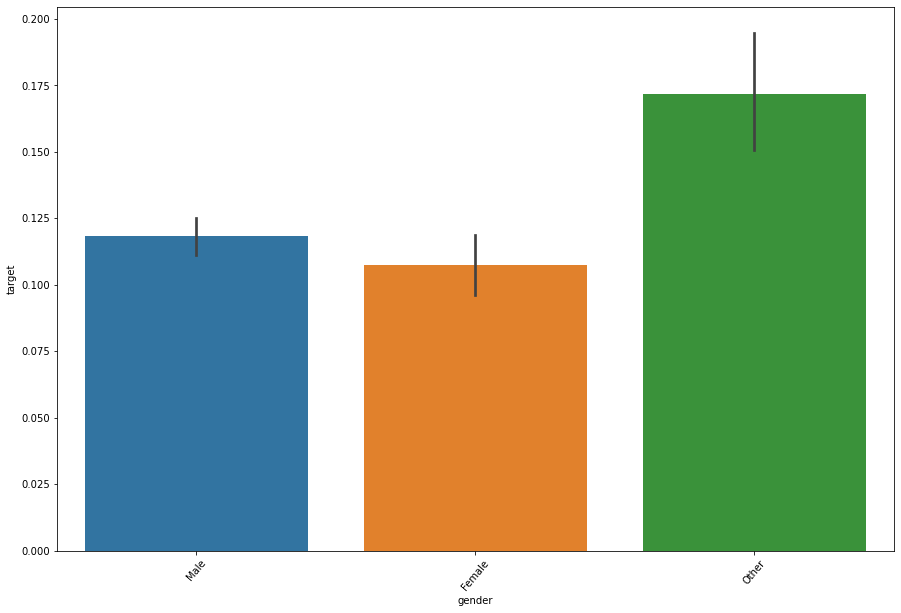

In [104]:
get_to_target_description(data, 'gender')

In [105]:
data.groupby('gender').count()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
gender,,,,,,,,,,,,
Female,3679,3679,3679,3679,3679,2681,1672,2971,1640,1632,3679,3327
Male,8356,8356,8356,8356,8356,5830,3383,6591,3621,3618,8356,7617
Other,1246,1246,1246,1246,1246,660,567,995,888,887,1246,1135


Мужчин пропорационально по всем параметрам в 2 раза больше, чем женщин. 

________________

Возраст

In [106]:
data['age'].describe()

count    13281.000000
mean        42.375574
std         93.170951
min      -6099.000000
25%         35.000000
50%         41.000000
75%         50.000000
max        320.000000
Name: age, dtype: float64

Рассмотрение выбросов

IQR 15.0

 Uniqie Outliers


array([   79,     2,   120,    81,     1,    11,    78,    12,    73,
          82,     7,    10,    76,     3,    93,    77,    80,     9,
           6,   -76,    -2,    89,    74,    75,    84,    90,   140,
           8,     5,    86,   320,   -12,    83,    85, -6099, -5939,
           4,   -22,   144,   112,     0,    88,   -27,    87,   133,
         102,   -51,   128,   -26,   100], dtype=int64)

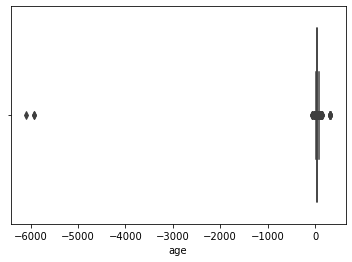

In [107]:
get_outliers(data, 'age')

Следует избавиться от аномалий, очень странно распределены значения возраста, особенно в том, что есть отрицательные значения.

In [108]:
data['age'] = data['age'].abs()

age_median = data['age'].median()

data.loc[(data['age'] <= 18)|(data['age'] >= 70),'age'] = age_median 

In [109]:
data.loc[:, 'age'] = age_cleaner(data, 'age')

IQR 11.0

 Uniqie Outliers


array([69, 64, 65, 67, 68, 66, 19], dtype=int64)

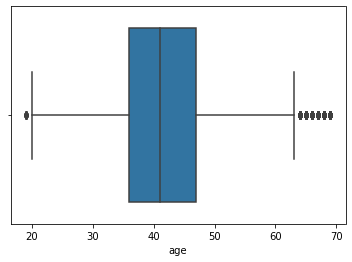

In [110]:
get_outliers(data, 'age')

train_index = data[data['target'].isna() == False].index
test_index = data[data['target'].isna() ==True].index

train_index.shape, test_index.shape

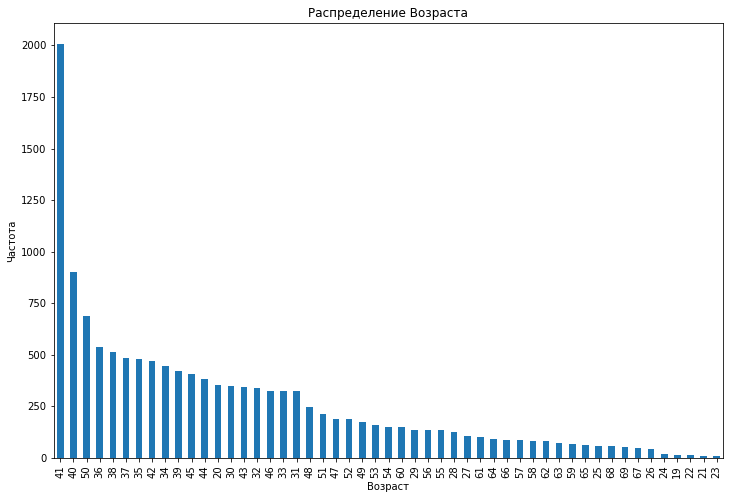

In [111]:
data['age'].value_counts().plot(kind='bar', figsize=(12, 8))
plt.title('Распределение Возраста', size=12)
plt.ylabel('Частота', size=10)
plt.xlabel('Возраст', size=10)
plt.show()

In [112]:
data['age'].describe()

count    13281.000000
mean        41.643702
std          9.502029
min         19.000000
25%         36.000000
50%         41.000000
75%         47.000000
max         69.000000
Name: age, dtype: float64

In [113]:
sum(data['age'].isnull())

0

In [114]:
data.groupby('age').count()

,psd,ped,gender,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
age,,,,,,,,,,,,
19,14,14,14,14,14,5,5,10,10,10,14,14
20,356,356,356,356,356,193,148,291,279,279,356,322
21,12,12,12,12,12,6,0,6,1,1,12,11
22,13,13,13,13,13,7,5,8,6,6,13,12
23,11,11,11,11,11,3,1,4,4,4,11,11
24,22,22,22,22,22,14,9,14,3,3,22,19
25,56,56,56,56,56,32,35,43,20,20,56,53
26,46,46,46,46,46,30,21,31,11,11,46,40
27,105,105,105,105,105,68,48,72,32,32,105,95


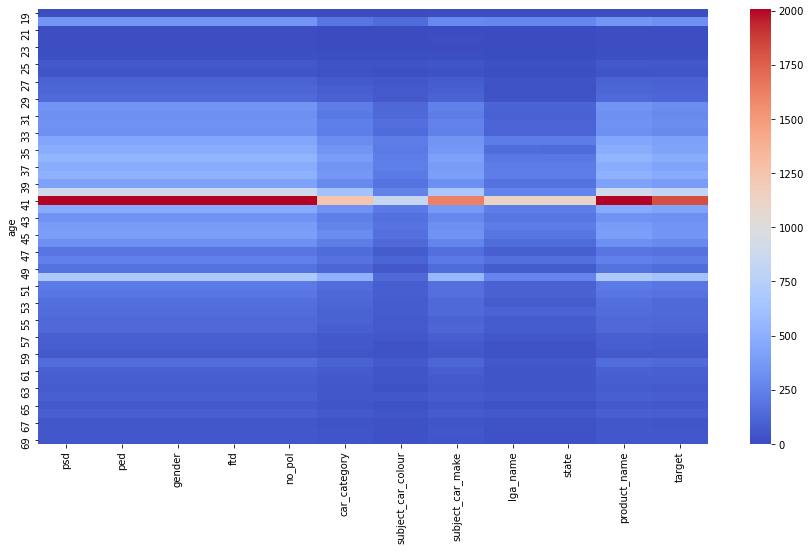

In [115]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(data.groupby('age').count(), cmap='coolwarm')
plt.show()

Наибольшее число людей лежит в возрасте от 35 до 48 лет.

______________

Возможно no_pol означает отсутсвие страховки, однако в тех же наблюдениях, где есть отметка no_pol стоит наличие стрховки. Так как описание данного признака изначально не приложено, следует на данном этапе оставить данную характеристику без интерпритаций

In [116]:
data['no_pol'].value_counts().reset_index().rename(columns={'index': 'значение', 'no_pol': 'количество' })

,значение,количество
0,1,10552
1,2,1864
2,3,590
3,4,214
4,5,25
5,7,19
6,10,9
7,6,8


следует избавиться от значений, которые встречаются слишком редко в выборке

In [117]:
data.loc[data['no_pol'] >= 5,'no_pol'] = 5 

распределение 1 к целевой перменной 0.10898
распределение 2 к целевой перменной 0.13738
распределение 3 к целевой перменной 0.20223
распределение 4 к целевой перменной 0.32039
распределение 5 к целевой перменной 0.05172


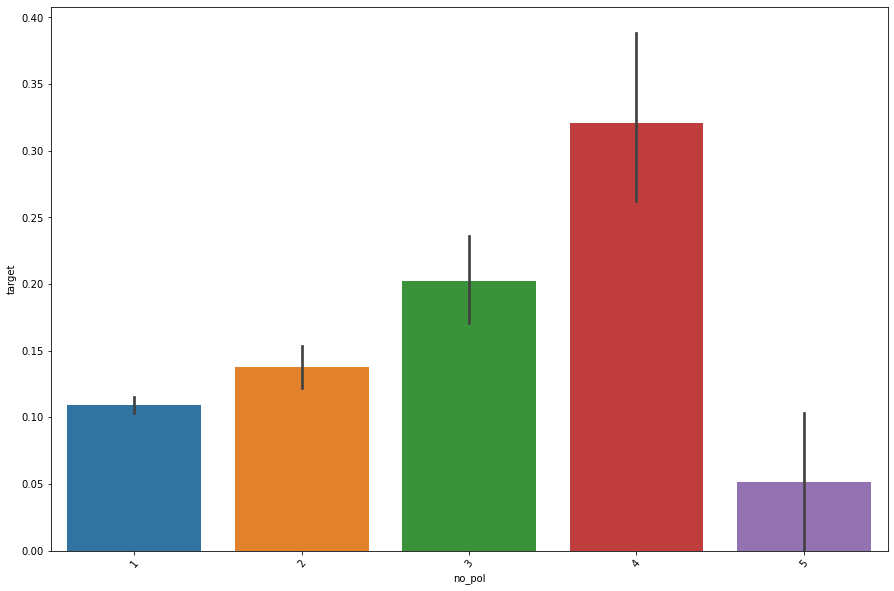

In [118]:
get_to_target_description(data, 'no_pol')

In [119]:
data.groupby('no_pol').count()

,psd,ped,gender,age,ftd,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
no_pol,,,,,,,,,,,,
1,10552,10552,10552,10552,10552,7357,4146,8190,3902,3892,10552,9580
2,1864,1864,1864,1864,1864,1267,985,1605,1456,1454,1864,1696
3,590,590,590,590,590,410,351,507,536,536,590,539
4,214,214,214,214,214,106,111,196,198,198,214,206
5,61,61,61,61,61,31,29,59,57,57,61,58


________________

Какие представлены категории машин?

Кол-во пустых значений

In [120]:
sum(data['car_category'].isnull())

4110

In [121]:
data['car_category'].value_counts().reset_index().rename(columns={'index': 'значение', 'car_category': 'количество' })

,значение,количество
0,Saloon,6633
1,JEEP,2223
2,Truck,108
3,Bus,56
4,Mini Bus,45
5,Pick Up,32
6,Motorcycle,18
7,Sedan,14
8,Mini Van,13
9,Wagon,10


распределение Saloon к целевой перменной 0.13507
распределение JEEP к целевой перменной 0.12271
распределение Truck к целевой перменной 0.24742
распределение Bus к целевой перменной 0.16667
распределение Mini Bus к целевой перменной 0.27778
распределение Pick Up к целевой перменной 0.26667
распределение Motorcycle к целевой перменной 0.11765
распределение Sedan к целевой перменной 0.41667
распределение Mini Van к целевой перменной 0.15385
распределение Wagon к целевой перменной 0.1
распределение Station 4 Wheel к целевой перменной 0.0
распределение Shape Of Vehicle Chasis к целевой перменной 0.33333
распределение Van к целевой перменной 0.33333
распределение Pick Up > 3 Tons к целевой перменной 0.0
распределение Tipper Truck к целевой перменной 0.0
распределение CAMRY CAR HIRE к целевой перменной 0.0


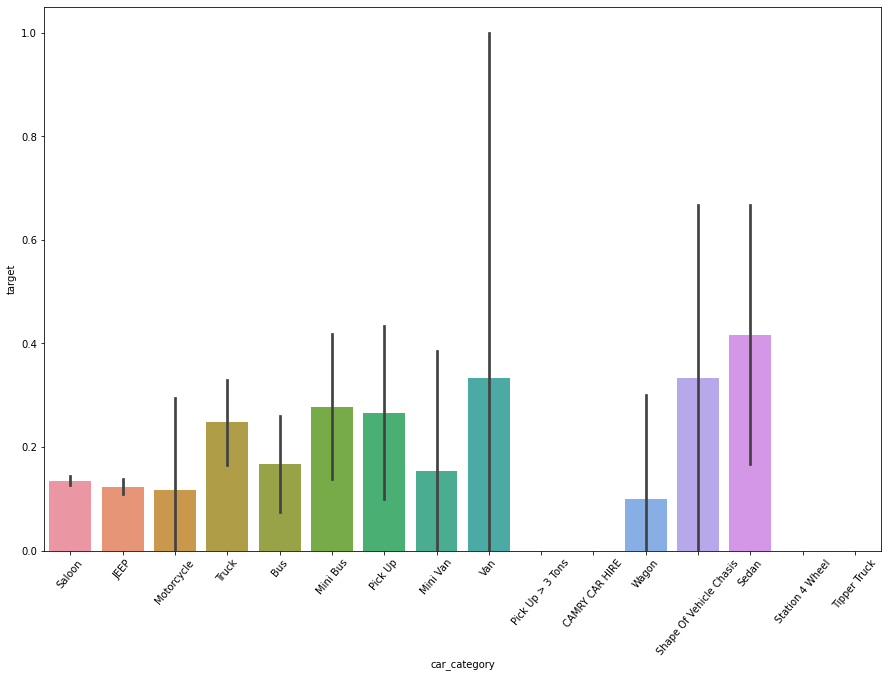

In [122]:
get_to_target_description(data, 'car_category')

Выделение уникальных типов авто

In [123]:
print(data['car_category'].unique())

['Saloon' 'JEEP' nan 'Motorcycle' 'Truck' 'Bus' 'Mini Bus' 'Pick Up'
 'Mini Van' 'Van' 'Pick Up > 3 Tons' 'CAMRY CAR HIRE' 'Wagon'
 'Shape Of Vehicle Chasis' 'Sedan' 'Station 4 Wheel' 'Tipper Truck']


Следует почистить данные, заменив некоторые значения, так как представлены явные ошибки

In [124]:
data.loc[data['car_category']=='Saloon','car_category'] = 'Sedan'

data['car_category']=data['car_category'].apply(car_type_mapper)

In [125]:
data.groupby('car_category').count()

,psd,ped,gender,age,ftd,no_pol,subject_car_colour,subject_car_make,lga_name,state,product_name,target
car_category,,,,,,,,,,,,
Bus,104,104,104,104,104,104,73,104,69,69,104,93
Sedan,8937,8937,8937,8937,8937,8937,4722,8936,4009,4000,8937,8131
Truck,111,111,111,111,111,111,92,111,106,105,111,99


распределение Sedan к целевой перменной 0.13295
распределение Truck к целевой перменной 0.24242
распределение Bus к целевой перменной 0.21505


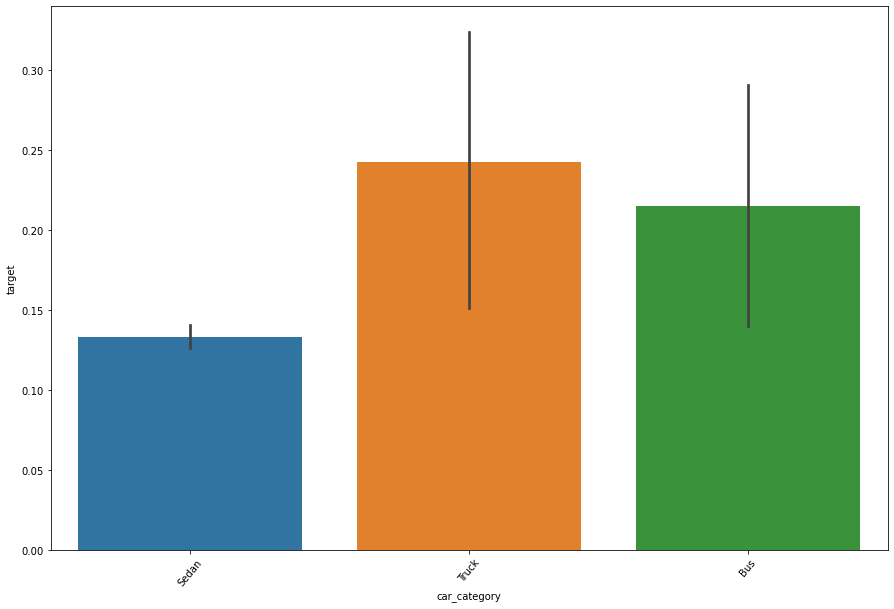

In [126]:
get_to_target_description(data, 'car_category')

In [127]:
data.isnull().sum()

psd                      0
ped                      0
gender                   0
age                      0
ftd                      0
no_pol                   0
car_category          4129
subject_car_colour    7659
subject_car_make      2724
lga_name              7132
state                 7144
product_name             0
target                1202
dtype: int64

Распределение значений цвета авто

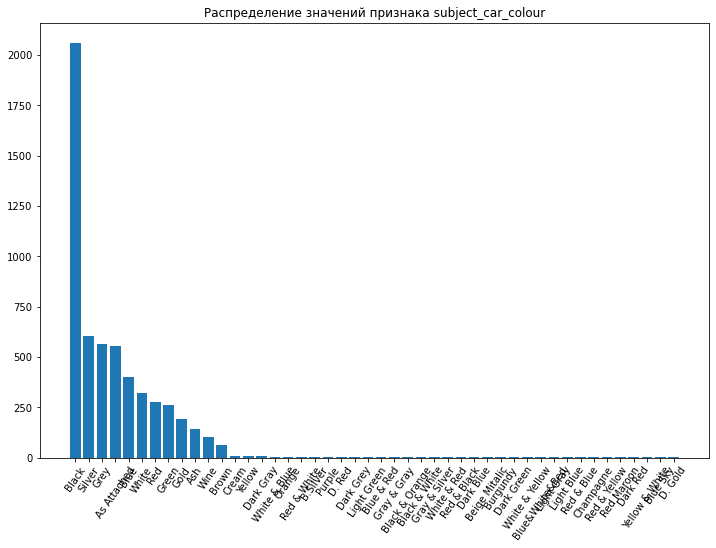

In [128]:
bar_vc(data, 'subject_car_colour', rotation=55)

Уникальные значения цвета авто

In [129]:
print(data['subject_car_colour'].unique())

['Black' 'Grey' 'Red' nan 'As Attached' 'Blue' 'Silver' 'Green' 'Ash'
 'White' 'Gray & Gray' 'Wine' 'Brown' 'Red & Blue' 'Gold' 'Gray & Silver'
 'Orange' 'Red & Black' 'Dark Grey' 'White & Red' 'Light Green'
 'Dark Gray' 'B.Silver' 'Purple' 'Blue & Red' 'Red & Yellow' 'Yellow'
 'Red & White' 'D. Red' 'Dark Red' 'Black & White' 'White & Blue' 'Cream'
 'Dark Green' 'D. Gold' 'Champagne' 'Light Blue' 'Blue&White&Red'
 'White & Yellow' 'Dark Blue' 'Black & Orange' 'Burgundy' 'Yellow & White'
 'Beige Mitalic' 'Light Gray' 'Blue Sky' 'Red Maroon']


Следует изменить значения, отчистив от лишних признаков и приведя некоторые из них к общему типу

In [130]:
data.loc[data['subject_car_colour']=='Gray & Gray','subject_car_colour'] ='Grey'
data.loc[data['subject_car_colour']=='Gray & Silver','subject_car_colour'] ='Grey'
data.loc[data['subject_car_colour']=='Dark Grey','subject_car_colour'] ='Grey'
data.loc[data['subject_car_colour']=='Light Gray','subject_car_colour'] ='Grey'
data.loc[data['subject_car_colour']=='D. Red','subject_car_colour'] ='Dark Red'

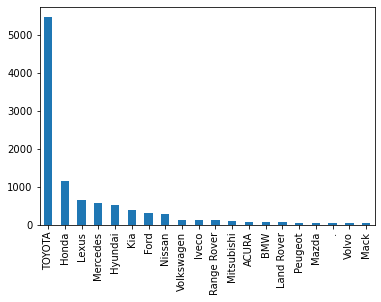

In [131]:
data['subject_car_make'].value_counts()[:20].plot(kind='bar');

Уникальные значения марок авто

In [132]:
print(data['subject_car_make'].unique())

['TOYOTA' nan 'REXTON' 'Lexus' 'Hyundai' 'Iveco' 'DAF' 'Honda' 'Mercedes'
 'Jincheng' 'ACURA' 'Ford' 'Volkswagen' 'Nissan' '.' 'Pontiac'
 'Range Rover' 'Kia' 'Mitsubishi' 'Scania' 'BMW' 'Infiniti' 'Renault'
 'Volvo' 'Hummer' 'Mack' 'Grand Cherokee' 'Porsche' 'Peugeot' 'Land Rover'
 'Chevrolet' 'Mazda' 'Man' 'Jeep' 'Audi' 'Suzuki' 'MINI COOPER' 'KA'
 'As Attached' 'Innson' 'Isuzu' 'Skoda' 'Jaguar' 'Chrysler' 'Dodge' 'GMC'
 'Land Rover.' 'Subaru' 'GAC' 'Fiat' 'Opel' 'Astra' 'Motorcycle' 'ZOYTE'
 'Seat' 'FOTON' 'Howo' 'Lincoln' 'Rols Royce' 'CHANGAN' 'LIBERTY' 'ABG'
 'Yamaha' 'Black' 'Tata' 'Ashok Leyland' 'Geely' 'Caddillac'
 'Wrangler Jeep' 'Raston' 'MG' 'BRILLIANCE' 'Buik' 'COMMANDER' 'Bajaj'
 'Datsun']


Здесь также слеует провести обработку данных, исправив ошибки в записях. 

In [133]:
data.loc[data['subject_car_make'] == 'Man','car_category'] = 'Truck'
data.loc[data['subject_car_make'] == 'Iveco','car_category'] = 'Truck'
data.loc[data['subject_car_make'] == 'Inson','car_category'] = 'Truck'
data.loc[data['subject_car_make']=='DAF','car_category'] ='Truck'
data.loc[data['subject_car_make']=='Howo','car_category'] ='Truck'
data.loc[data['subject_car_make']=='Mack','car_category'] ='Truck'

data.loc[data['subject_car_make']=='Cadillac ','car_category'] ='Sedan'
data.loc[data['subject_car_make']=='Rols Royce','car_category'] = 'Sedan'
data.loc[data['subject_car_make']=='Jincheng','car_category'] ='Sedan'
data.loc[data['subject_car_make']=='Isuzu','car_category'] ='Sedan'

data.loc[data['subject_car_make']=='KA','subject_car_make'] ='Ford'

data.loc[data['subject_car_make']=='Range Rover','subject_car_make'] = 'Land Rover'
data.loc[data['subject_car_make']=='Range Rover','subject_car_make'] = 'Land Rover'
data.loc[data['subject_car_make']=='Land Rover.','subject_car_make'] = 'Land Rover'

data.loc[data['subject_car_make']=='Grand Cherokee','subject_car_make'] = 'Jeep'
data.loc[data['subject_car_make']=='Wrangler Jeep','subject_car_make'] = 'Jeep'
data.loc[data['subject_car_make'] == 'Hummer','car_category'] ='JEEP'

data['subject_car_make']=data['subject_car_make'].apply(subject_car_mapper)

In [134]:
data.groupby('subject_car_make').count()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,lga_name,state,product_name,target
subject_car_make,,,,,,,,,,,,
ABG,1,1,1,1,1,1,1,0,1,1,1,1
ACURA,69,69,69,69,69,69,63,42,38,38,69,65
Astra,2,2,2,2,2,2,0,2,2,2,2,2
Audi,33,33,33,33,33,33,19,24,20,20,33,30
BMW,68,68,68,68,68,68,52,34,40,40,68,63
CHANGAN,1,1,1,1,1,1,1,1,1,1,1,1
Chevrolet,26,26,26,26,26,26,25,6,9,9,26,23
Chrysler,2,2,2,2,2,2,2,1,1,1,2,2
DAF,21,21,21,21,21,21,21,16,20,20,21,20


Тойотой переполнен датасет.

Распределение названий городов

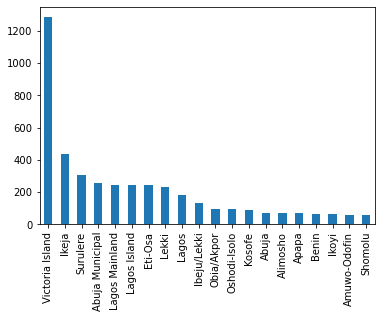

In [135]:
data['lga_name'].value_counts()[:20].plot(kind='bar');

Рассмотрение уникальных значений

In [136]:
print(data['lga_name'].unique())

[nan 'Lagos' 'Ikeja' 'Badagry' 'Eti-Osa' 'Victoria Island' 'Ikoyi'
 'Lagos Mainland' 'EFFURUN' 'Abeokuta' 'Abuja Municipal' 'Yaba' 'Aguda'
 'Surulere' 'Oshodi-Isolo' 'Alimosho' 'Okpe, Delta State' 'Asaba'
 'IbadanCentral' 'Lekki' 'Ibeju/Lekki' 'OBANIKORO' 'Agege' 'ISHERI'
 'Kosofe' 'OGUN' 'Apapa' 'Ibadan South West' 'Obia/Akpor'
 'Ibadan South East' 'Sapele' 'Kaduna South' 'Ikorodu' 'Amuwo-Odofin'
 'Awka' 'GBAGADA' 'Port Harcourt' 'Minna' 'Shomolu' 'Benin' 'Lagos Island'
 'Central' 'Ebute-Metta' 'Ketu' 'Uyo' 'Mushin' 'Katagum' 'ENUGU EAST'
 'Oredo' 'Abuja' 'Festac' 'Ipaja' 'Zaria ' 'Esan West' 'Oluyole' 'Bwari'
 'Obafemi-Owode' 'LGA' 'Orile-Iganmu' 'Egbeda' 'Ido' 'Ifako-Ijaye '
 'Ibadan North' 'Oguta' 'Jos North' 'Ajah' 'Ondo West' 'Kaduna North'
 'Warri' 'Aniocha South' 'Owerri' 'Awka South' 'Asokoro District'
 'Ile-Oluji' 'Ijebu Ode' 'Port-Harcourt' 'Oshodi' 'EMENE' 'Alagbado'
 'Wuse 11' 'Egor' 'Biase' 'Shagamu' 'Nnewi North' 'Aboh-Mbaise'
 'IBADAN NORTH EAST' 'Akinyele' 'Oyo' 'Akoko

____________

Распредеелние штатов

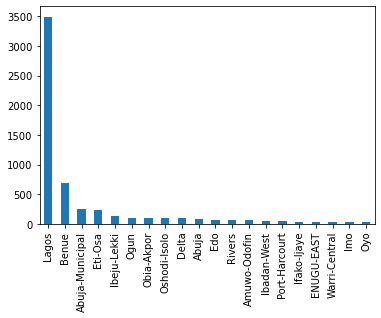

In [137]:
data['state'].value_counts()[:20].plot(kind='bar');

Уникальные значения

In [138]:
print(data['state'].unique())

[nan 'Lagos' 'Benue' 'Eti-Osa' 'Delta' 'Ogun' 'Abuja-Municipal'
 'Oshodi-Isolo' 'Ibeju-Lekki' 'Ibadan-West' 'Obia-Akpor' 'Ibadan-East'
 'Kaduna-South' 'Amuwo-Odofin' 'Anambra' 'Rivers' 'Niger-State' 'Edo'
 'Akwa-Ibom' 'ENUGU-EAST' 'Abuja' 'Kaduna' 'Esan-West' 'Obafemi-Owode'
 'Orile-Iganmu' 'Ifako-Ijaye' 'Ibadan-North' 'Imo' 'Jos-North' 'Ondo-West'
 'Kaduna-North' 'Aniocha-South' 'Awka-South' 'Ile-Oluji' 'Ijebu-Ode'
 'Port-Harcourt' 'Nnewi-North' 'Aboh-Mbaise' 'Oyo' 'Akoko-West'
 'Warri-Central' 'Cross-River' 'Jos-South' 'Onitsha-North' 'Osun'
 'Ajeromi-Ifelodun' 'Kano-Municipal' 'Ife-Central' 'Ilorin-West'
 'Lagelu-North' 'Owerri-Municipal' 'Nsit-Ubium' 'Udi-Agwu' 'Essien-Udim'
 'Owerri-West' 'Ondo' 'Ogbmosho-South' 'Umuahia-South' 'ABULE-EGBA'
 'Enugu-North' 'Ovia-SouthWest' 'Kebbi' 'Ajegunle-State' 'Ekiti-West'
 'Ogun-Waterside' 'Ife-North' 'Anambra-East' 'Nasarawa' 'Etsako-West'
 'Kwara' 'Aba-North' 'Awka-North' 'Ibarapa-Central' 'Idemili-North'
 'Ogba-Ndoni' 'Calabar-Municipality'

Распределение названия продуктов авто

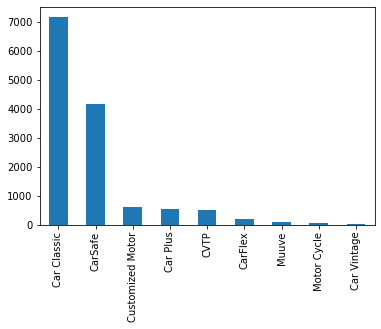

In [139]:
data['product_name'].value_counts()[:20].plot(kind='bar');

Уникальные значения признака названия продуктов авто

In [140]:
print(data['product_name'].unique())

['Car Classic' 'CarSafe' 'Muuve' 'CVTP' 'Car Plus' 'Motor Cycle'
 'Customized Motor' 'CarFlex' 'Car Vintage']


Следует исправить некоторые значения в данном признаке, так как допущены определенные ошибки при записи.

In [141]:
data.loc[data['product_name'] == 'Muuve','car_category'] = 'Sedan'
data.loc[data['product_name'] == 'CarSafe','car_category'] = 'Sedan'
data.loc[data['product_name'] == 'Car Plus','car_category'] = 'Sedan'
data.loc[data['product_name'] == 'CarFlex','car_category'] = 'Sedan'

data.loc[data['product_name'] == 'Motor Cycle','car_category'] = 'Motorcycle'
data.loc[data['product_name'] == 'Motor Cycle','car_category'] = 'Motorcycle'

In [142]:
data.groupby('product_name').count()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,target
product_name,,,,,,,,,,,,
CVTP,509,509,509,509,509,509,290,277,409,480,480,469
Car Classic,7142,7142,7142,7142,7142,7142,5124,4516,5956,4283,4276,6485
Car Plus,523,523,523,523,523,523,523,314,436,274,272,486
Car Vintage,5,5,5,5,5,5,5,2,5,3,3,5
CarFlex,194,194,194,194,194,194,194,26,154,17,17,176
CarSafe,4154,4154,4154,4154,4154,4154,4154,89,2918,370,367,3774
Customized Motor,605,605,605,605,605,605,405,335,596,577,577,545
Motor Cycle,49,49,49,49,49,49,49,26,32,46,46,46
Muuve,100,100,100,100,100,100,100,37,51,99,99,93


_______________

Рассмотреть целевой переменной

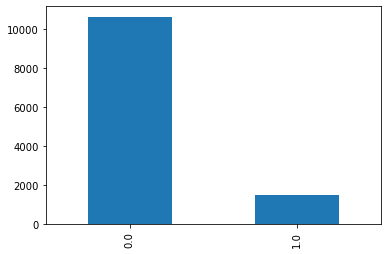

In [429]:
data['target'].value_counts().plot(kind='bar');

In [430]:
len(data)

13281

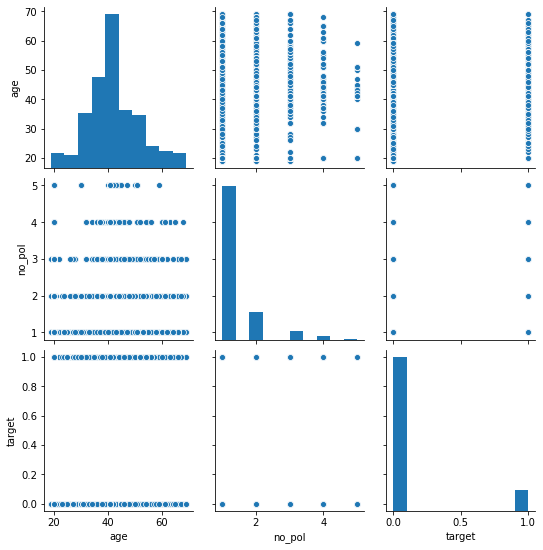

In [144]:
sns.pairplot(data);

In [145]:
data.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve,1.0


## Вывод:

Произведена обработка временных значений, gender, car_category, subject_car_color, subject_car_make, product_name. 
Устранены ошибки в записях. В пирзнаке возраста устранены выбросы.

Целевая переменная распределена 1 к 5. 
Пустые значения будут заполнены различными методами позднее.


______________________

## Заполнение пустых значений

In [146]:
dataframe = data.copy()

In [147]:
dataframe.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve,1.0


Сохранение индексов записей с пустыми значениями

In [148]:
car_category_index = dataframe['car_category'].dropna().index
subject_car_colour_index = dataframe['subject_car_colour'].dropna().index
subject_car_make_index = dataframe['subject_car_make'].dropna().index
lga_name_index = dataframe['lga_name'].dropna().index
state_index = dataframe['state'].dropna().index

Создание энкодеров

In [149]:
car_category_oe = OrdinalEncoder()
subject_car_colour_oe = OrdinalEncoder()
subject_car_make_oe = OrdinalEncoder()
lga_name_oe = OrdinalEncoder()
state_oe = OrdinalEncoder()

Трансформация значений

In [150]:
car_category_oe_result = car_category_oe.fit_transform(dataframe.loc[:, ['car_category']].dropna())
subject_car_colour_oe_result = subject_car_colour_oe.fit_transform(dataframe.loc[:, ['subject_car_colour']].dropna())
subject_car_make_oe_result = subject_car_make_oe.fit_transform(dataframe.loc[:, ['subject_car_make']].dropna())
lga_name_oe_result = lga_name_oe.fit_transform(dataframe.loc[:, ['lga_name']].dropna())
state_oe_result = state_oe.fit_transform(dataframe.loc[:, ['state']].dropna())

Перезапись датафрейма с учетом трансформированных значений

In [151]:
dataframe.loc[car_category_index, 'car_category'] = car_category_oe_result
dataframe.loc[subject_car_colour_index, 'subject_car_colour'] = subject_car_colour_oe_result
dataframe.loc[subject_car_make_index, 'subject_car_make'] = subject_car_make_oe_result
dataframe.loc[lga_name_index, 'lga_name'] = lga_name_oe_result
dataframe.loc[state_index, 'state'] = state_oe_result

In [152]:
dataframe.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,3,4,48,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,3,22,48,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,3,27,48,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,3,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,3,NaN,NaN,165,74,Muuve,1.0


Следует попробовать воспользоваться моделью KNN Imputer, которая с помощью метода ближайших соседей определит возможные пропавшие значения

In [153]:
X = dataframe.drop(['psd', 'ped', 'ftd','target', 'gender', 'product_name'], axis=1)

In [154]:
X.head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state
0,30,1,3,4,48,NaN,NaN
1,41,1,3,22,48,NaN,NaN
2,43,1,3,27,48,NaN,NaN
3,41,1,3,NaN,NaN,NaN,NaN
4,20,3,3,NaN,NaN,165,74


Определение Imputer

In [155]:
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

Обучение на датасете

In [156]:
imputer.fit(X)

KNNImputer()

Трансформация датасета

In [157]:
Xtrans = imputer.transform(X)

Создание датафрейма с трансформированного моделью значениями

In [158]:
Xtrans_df = pd.DataFrame(data=Xtrans, columns=X.columns)

In [159]:
Xtrans_df.head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state
0,30.0,1.0,3.0,4.0,48.0,151.4,80.4
1,41.0,1.0,3.0,22.0,48.0,216.2,45.0
2,43.0,1.0,3.0,27.0,48.0,144.6,55.6
3,41.0,1.0,3.0,18.4,36.6,197.0,60.0
4,20.0,3.0,3.0,0.0,24.0,165.0,74.0


Процент пустых значений

In [160]:
print('Missing: %d' % sum(np.isnan(Xtrans).flatten()))

Missing: 0


Произведение обратной трансформации значений

In [161]:
dataframe['car_category'] = car_category_oe.inverse_transform(Xtrans_df.loc[:, ['car_category']])
dataframe['subject_car_colour'] = subject_car_colour_oe.inverse_transform(Xtrans_df.loc[:, ['subject_car_colour']])
dataframe['subject_car_make'] = subject_car_make_oe.inverse_transform(Xtrans_df.loc[:, ['subject_car_make']])
dataframe['lga_name'] = lga_name_oe.inverse_transform(Xtrans_df.loc[:, ['lga_name']])
dataframe['state'] = state_oe.inverse_transform(Xtrans_df.loc[:, ['state']])

Проверка на пустые значения

In [162]:
dataframe.isnull().sum()

psd                      0
ped                      0
gender                   0
age                      0
ftd                      0
no_pol                   0
car_category             0
subject_car_colour       0
subject_car_make         0
lga_name                 0
state                    0
product_name             0
target                1202
dtype: int64

Насколько хорошо отработал Imputer? Следует проверить это с помощью модели RandomForestClassifier

In [163]:
X = Xtrans_df.iloc[dataframe[dataframe['target'].isna() == False].index]
y = dataframe[dataframe['target'].isna() == False]['target']

In [164]:
Xtrans_df.isna().sum()

age                   0
no_pol                0
car_category          0
subject_car_colour    0
subject_car_make      0
lga_name              0
state                 0
dtype: int64

In [165]:
y.isna().sum()

0

In [166]:
# Определение модели
model = RandomForestClassifier()
imputer = KNNImputer()
pipeline = Pipeline(steps=[('i', imputer), ('m', model)])


# определение метрики оценки модели
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# оценка модели
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean Accuracy: 0.850 (0.007)


Достаточно высокая метрика точности. Этого будет достаточно, чтобы оставить результат Imputer. Предполагается, что этот вариант лучше, чем заполнение каким-то унифицированным значением. Это предположение будет в дальнейшем проверено на работе моделей.

Датафрейм с заполненными нанами с помощью KNNImputer

In [167]:
dataframe.isna().sum()

psd                      0
ped                      0
gender                   0
age                      0
ftd                      0
no_pol                   0
car_category             0
subject_car_colour       0
subject_car_make         0
lga_name                 0
state                    0
product_name             0
target                1202
dtype: int64

In [168]:
df = dataframe.copy()

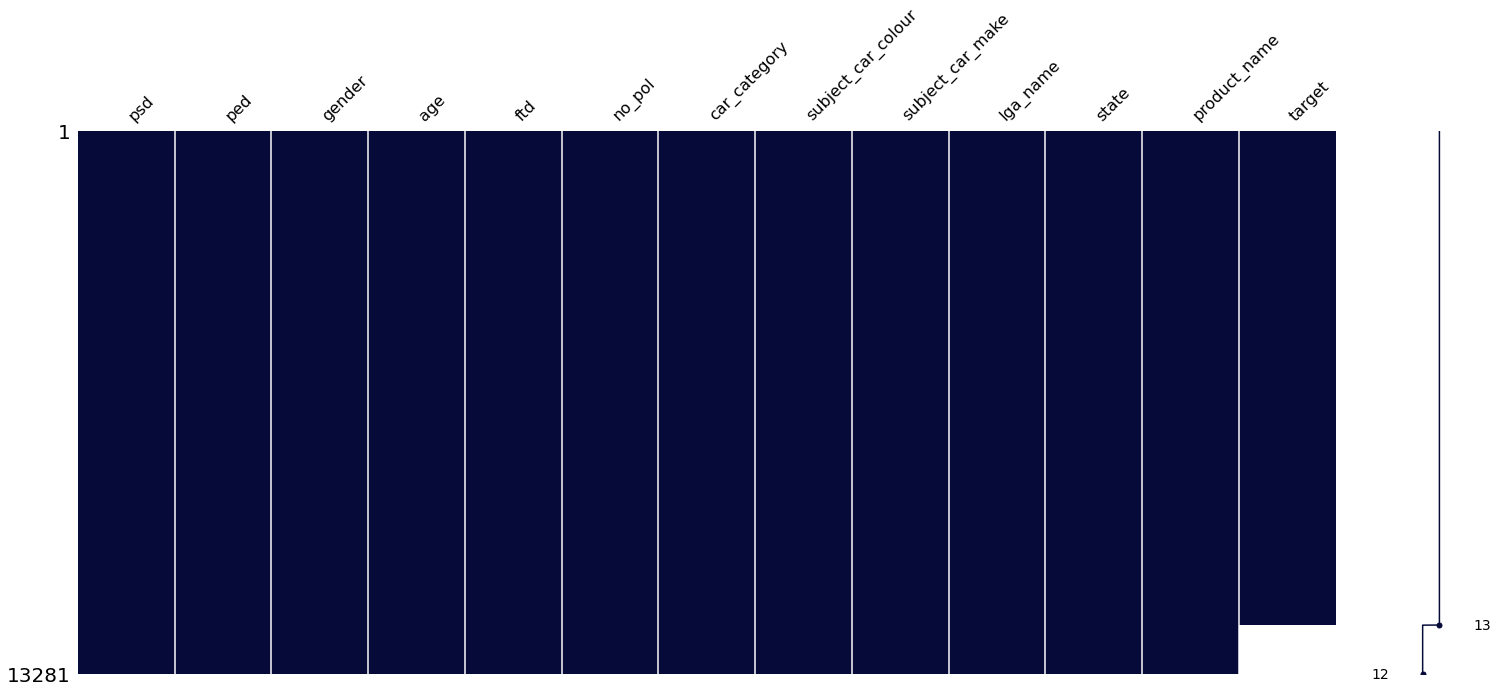

In [169]:
msn.matrix(df, color=(0.02, 0.04, 0.22));

In [170]:
df.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,Kaduna North,Nnewi-North,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,Oredo,Ibarapa-Central,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,Isoko south,Ile-Oluji,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,Dark Green,Nissan,Ogba/Egbema/Ndoni,Imo,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,As Attached,Jincheng,Lagos,Lagos,Muuve,1.0


##  Генерация признаков


In [171]:
df = dataframe.copy()

In [172]:
(df['ped'] - df['psd'])[0].days

364

Создание временнЫх признаков. Здесь происхожит выделение года, месяца и дня, а также их дельты в отдельные признаки в данных

In [173]:
df['year_psd'] = df['psd'].apply(lambda x: x.year)
df['year_ped'] = df['ped'].apply(lambda x: x.year)
df['f_m'] = df['psd'].apply(lambda x: x.month)
df['l_m'] = df['ped'].apply(lambda x: x.month)
df['f_d'] = df['psd'].apply(lambda x: x.day)
df['l_d'] = df['ped'].apply(lambda x: x.day)


df['delta_year_pd'] = df['year_ped'] - df['year_psd']
df['delta_days'] = (df['ped'] - df['psd'])
df['delta_days'] = df['delta_days'].apply(lambda x: x.days)

#df['insurance_duration'] = df['year_ped'] - df['year_psd'] 

In [174]:
df.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,...,product_name,target,year_psd,year_ped,f_m,l_m,f_d,l_d,delta_year_pd,delta_days
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,Kaduna North,...,Car Classic,0.0,2010,2011,5,5,14,13,1,364
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,Oredo,...,Car Classic,1.0,2010,2011,11,11,29,28,1,364
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,Isoko south,...,Car Classic,0.0,2010,2011,3,3,21,20,1,364
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,Dark Green,Nissan,Ogba/Egbema/Ndoni,...,CarSafe,0.0,2010,2011,8,8,21,20,1,364
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,As Attached,Jincheng,Lagos,...,Muuve,1.0,2010,2010,8,12,29,31,0,124


Как признаки коррелируют друг с другом?

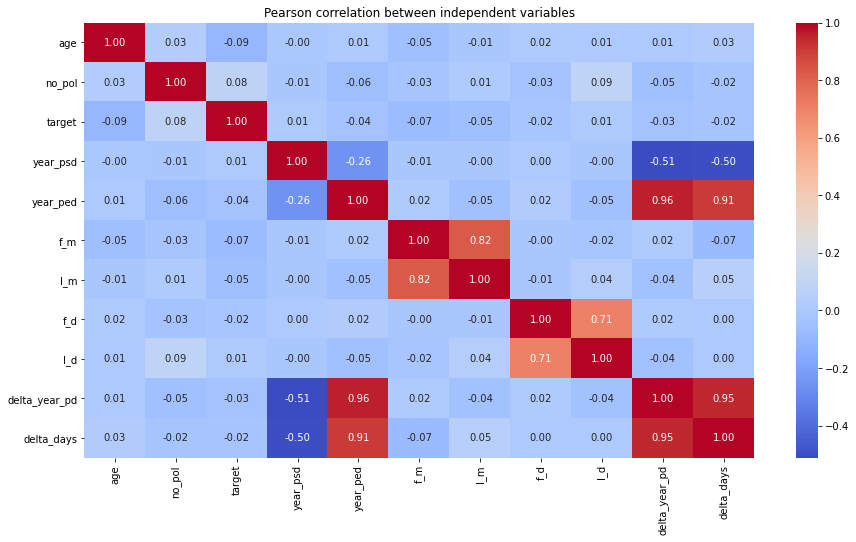

In [175]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Pearson correlation between independent variables')
plt.show()

В целом корреляция признаков друг с другом незначительна, однако некоторые новые полученные временные признаки слежует устранить, так как они дублируют сами себя. 

In [176]:
df.drop(['psd', 'ped', 'ftd', 'delta_year_pd', 'delta_days','l_m', 'l_d'], axis=1, inplace=True)

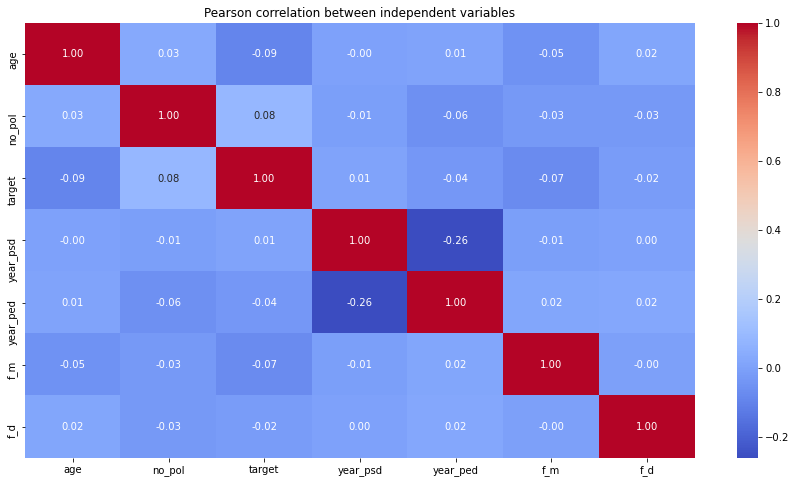

In [177]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Pearson correlation between independent variables')
plt.show()

Предлагается оставить данные как есть. Корреляция признаков незначительна

Выделение математический признаков

In [178]:
# средняя по возрасту
df['gender_mean'] = df['gender'].replace(df.groupby(['gender']).mean()['age'].to_dict())

In [179]:
# стандартное отклонение по возрасту
df['gender_std'] = df['gender'].replace(df.groupby(['gender']).std()['age'].to_dict())

In [180]:
print('Уникальные значения возраста')
print(df['age'].sort_values().unique())

Уникальные значения возраста
[19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69]


Разбиение возраста на несколько числовых категорий

In [181]:
df['age_marked'] = get_age_mark(df, 'age')

Рассмотрение корреляции признаков

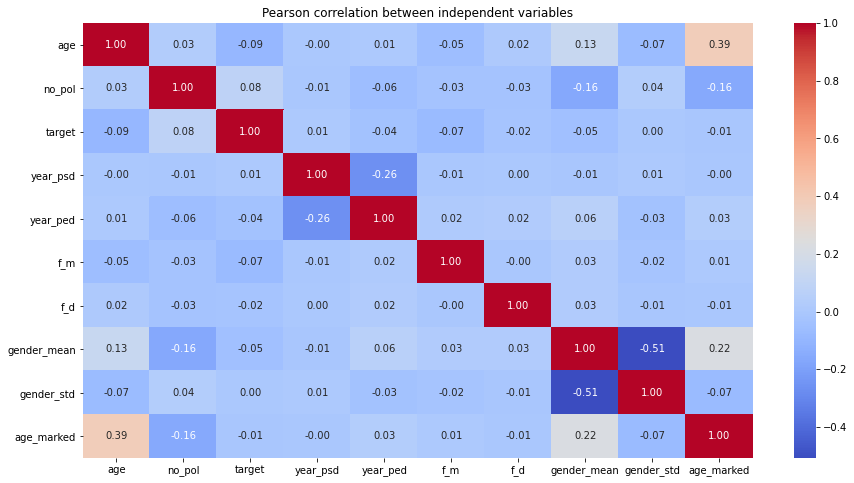

In [182]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Pearson correlation between independent variables')
plt.show()

В данных пhисутсвует приемлимая корреляция. Устранять признаки не требуется

Выделение отдельного датафрейма без математических признаков. Может понадобиться для жкспериментов.

In [183]:
df_no_math = df.copy()

Суммирование и умножение числовых признаков

In [184]:
df['age+no_pol'] = df['age'] + df['no_pol']
#df['age+insurance_duration'] = df['age'] + df['insurance_duration']
#df['insurance_duration+no_pol'] = df['insurance_duration'] + df['no_pol']

df['age*no_pol'] = df['age'] * df['no_pol']
#df['age*insurance_duration'] = df['insurance_duration'] * df['age']
#df['insurance_duration*no_pol'] = df['insurance_duration'] * df['no_pol']

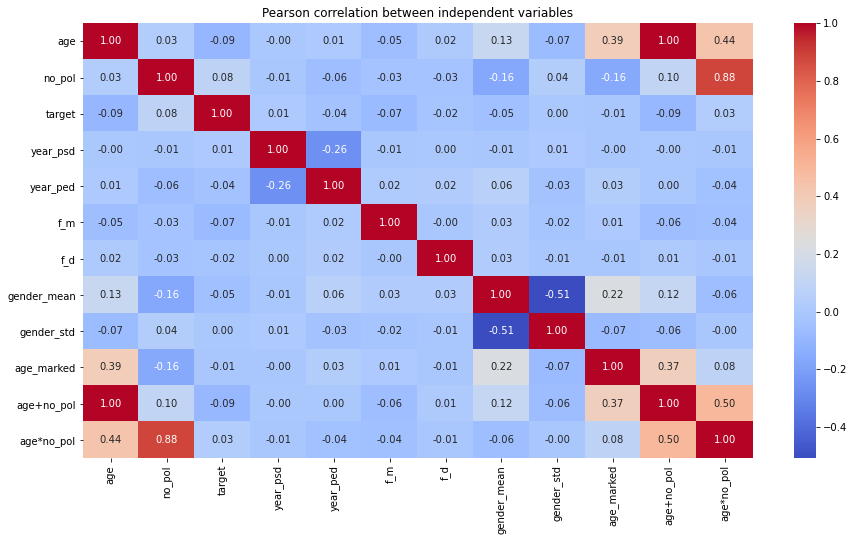

In [185]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Pearson correlation between independent variables')
plt.show()

В данных присутсвует приемлимая корреляция. Устранять признаки не требуется

Данный датафрейм останется без изменений для модели Catboost

In [186]:
df_catboost = df.copy()

# Подготовка данных для построения моедели

Генерация OneHotEncoding на данных пола.

In [187]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [188]:
ohe_result = ohe.fit_transform(df.loc[:, ['gender']]).toarray()

In [189]:
ohe_result

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [190]:
df['female'] = ohe_result[:, 0]
df['male'] = ohe_result[:, 1]
df['other'] = ohe_result[:, 2]
df.drop('gender', axis=1, inplace=True)

Выделение категориальных переменных

In [191]:
cat_feats = ['car_category', 'subject_car_colour', 'subject_car_make', 'lga_name', 'product_name']

Создание значений с mean_target_encoding

In [192]:
get_mean_target_encoding(df, 'state').head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,...,f_m,f_d,gender_mean,gender_std,age_marked,age+no_pol,age*no_pol,female,male,other
0,30,1,Sedan,Black,TOYOTA,Kaduna North,0.08046,Car Classic,0.0,2010,...,5,14,42.182982,9.170616,1,31,30,0.0,1.0,0.0
1,41,1,Sedan,Grey,TOYOTA,Oredo,0.13675,Car Classic,1.0,2010,...,11,29,41.703996,9.854635,1,42,41,1.0,0.0,0.0
2,43,1,Sedan,Red,TOYOTA,Isoko south,0.10268,Car Classic,0.0,2010,...,3,21,42.182982,9.170616,1,44,43,0.0,1.0,0.0
3,41,1,Sedan,Dark Green,Nissan,Ogba/Egbema/Ndoni,0.05374,CarSafe,0.0,2010,...,8,21,42.182982,9.170616,1,42,41,0.0,1.0,0.0
4,20,3,Sedan,As Attached,Jincheng,0.16069,0.16069,Muuve,1.0,2010,...,8,29,37.849117,9.768634,0,23,60,0.0,0.0,1.0


In [193]:
df['state'].fillna(np.random.uniform(0, 1), inplace=True)

In [194]:
get_mean_target_encoding(df, 'car_category').head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,...,f_m,f_d,gender_mean,gender_std,age_marked,age+no_pol,age*no_pol,female,male,other
0,30,1,0.11566,Black,TOYOTA,Kaduna North,0.08046,Car Classic,0.0,2010,...,5,14,42.182982,9.170616,1,31,30,0.0,1.0,0.0
1,41,1,0.11566,Grey,TOYOTA,Oredo,0.13675,Car Classic,1.0,2010,...,11,29,41.703996,9.854635,1,42,41,1.0,0.0,0.0
2,43,1,0.11566,Red,TOYOTA,Isoko south,0.10268,Car Classic,0.0,2010,...,3,21,42.182982,9.170616,1,44,43,0.0,1.0,0.0
3,41,1,0.11566,Dark Green,Nissan,Ogba/Egbema/Ndoni,0.05374,CarSafe,0.0,2010,...,8,21,42.182982,9.170616,1,42,41,0.0,1.0,0.0
4,20,3,0.11566,As Attached,Jincheng,0.16069,0.16069,Muuve,1.0,2010,...,8,29,37.849117,9.768634,0,23,60,0.0,0.0,1.0


In [195]:
get_mean_target_encoding(df, 'subject_car_colour').head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,...,f_m,f_d,gender_mean,gender_std,age_marked,age+no_pol,age*no_pol,female,male,other
0,30,1,0.11566,0.13560,TOYOTA,Kaduna North,0.08046,Car Classic,0.0,2010,...,5,14,42.182982,9.170616,1,31,30,0.0,1.0,0.0
1,41,1,0.11566,0.15551,TOYOTA,Oredo,0.13675,Car Classic,1.0,2010,...,11,29,41.703996,9.854635,1,42,41,1.0,0.0,0.0
2,43,1,0.11566,0.21739,TOYOTA,Isoko south,0.10268,Car Classic,0.0,2010,...,3,21,42.182982,9.170616,1,44,43,0.0,1.0,0.0
3,41,1,0.11566,0.02863,Nissan,Ogba/Egbema/Ndoni,0.05374,CarSafe,0.0,2010,...,8,21,42.182982,9.170616,1,42,41,0.0,1.0,0.0
4,20,3,0.11566,0.28522,Jincheng,0.16069,0.16069,Muuve,1.0,2010,...,8,29,37.849117,9.768634,0,23,60,0.0,0.0,1.0


In [196]:
df['subject_car_colour'].fillna(np.random.uniform(0, .8125),inplace=True)

In [197]:
get_mean_target_encoding(df, 'subject_car_make').head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,...,f_m,f_d,gender_mean,gender_std,age_marked,age+no_pol,age*no_pol,female,male,other
0,30,1,0.11566,0.13560,0.15645,Kaduna North,0.08046,Car Classic,0.0,2010,...,5,14,42.182982,9.170616,1,31,30,0.0,1.0,0.0
1,41,1,0.11566,0.15551,0.15645,Oredo,0.13675,Car Classic,1.0,2010,...,11,29,41.703996,9.854635,1,42,41,1.0,0.0,0.0
2,43,1,0.11566,0.21739,0.15645,Isoko south,0.10268,Car Classic,0.0,2010,...,3,21,42.182982,9.170616,1,44,43,0.0,1.0,0.0
3,41,1,0.11566,0.02863,0.03784,Ogba/Egbema/Ndoni,0.05374,CarSafe,0.0,2010,...,8,21,42.182982,9.170616,1,42,41,0.0,1.0,0.0
4,20,3,0.11566,0.28522,0.26415,0.16069,0.16069,Muuve,1.0,2010,...,8,29,37.849117,9.768634,0,23,60,0.0,0.0,1.0


In [198]:
df['subject_car_make'].fillna(np.random.uniform(0, .8125),inplace=True)

In [199]:
df['lga_name'] = get_lga_name_changer(df, 'lga_name')

In [200]:
get_mean_target_encoding(df, 'lga_name').head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,...,f_m,f_d,gender_mean,gender_std,age_marked,age+no_pol,age*no_pol,female,male,other
0,30,1,0.11566,0.13560,0.15645,0.09701,0.08046,Car Classic,0.0,2010,...,5,14,42.182982,9.170616,1,31,30,0.0,1.0,0.0
1,41,1,0.11566,0.15551,0.15645,0.22951,0.13675,Car Classic,1.0,2010,...,11,29,41.703996,9.854635,1,42,41,1.0,0.0,0.0
2,43,1,0.11566,0.21739,0.15645,0.09859,0.10268,Car Classic,0.0,2010,...,3,21,42.182982,9.170616,1,44,43,0.0,1.0,0.0
3,41,1,0.11566,0.02863,0.03784,0.01339,0.05374,CarSafe,0.0,2010,...,8,21,42.182982,9.170616,1,42,41,0.0,1.0,0.0
4,20,3,0.11566,0.28522,0.26415,0.10708,0.16069,Muuve,1.0,2010,...,8,29,37.849117,9.768634,0,23,60,0.0,0.0,1.0


In [201]:
df['lga_name'].fillna(np.random.uniform(0, 1), inplace=True)

In [202]:
get_mean_target_encoding(df, 'product_name').head()

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,...,f_m,f_d,gender_mean,gender_std,age_marked,age+no_pol,age*no_pol,female,male,other
0,30,1,0.11566,0.13560,0.15645,0.09701,0.08046,0.16561,0.0,2010,...,5,14,42.182982,9.170616,1,31,30,0.0,1.0,0.0
1,41,1,0.11566,0.15551,0.15645,0.22951,0.13675,0.16561,1.0,2010,...,11,29,41.703996,9.854635,1,42,41,1.0,0.0,0.0
2,43,1,0.11566,0.21739,0.15645,0.09859,0.10268,0.16561,0.0,2010,...,3,21,42.182982,9.170616,1,44,43,0.0,1.0,0.0
3,41,1,0.11566,0.02863,0.03784,0.01339,0.05374,0.00371,0.0,2010,...,8,21,42.182982,9.170616,1,42,41,0.0,1.0,0.0
4,20,3,0.11566,0.28522,0.26415,0.10708,0.16069,0.69892,1.0,2010,...,8,29,37.849117,9.768634,0,23,60,0.0,0.0,1.0


In [203]:
df.isna().sum()

age                      0
no_pol                   0
car_category             0
subject_car_colour       0
subject_car_make         0
lga_name                 0
state                    0
product_name             0
target                1202
year_psd                 0
year_ped                 0
f_m                      0
f_d                      0
gender_mean              0
gender_std               0
age_marked               0
age+no_pol               0
age*no_pol               0
female                   0
male                     0
other                    0
dtype: int64

## Вывод:

Было произведено заполнение пустых значений с помощью модели KNN Imputer, созданы дополнительные признаки, а также произведена обработка OneHotEncoder у признака пола. А также MeanTargetEncoder у категориальных признаков

## 

# Эксперимент 1

## Oбработка данных: KNN Imputer + mean target enc.

## CATBOOST

In [204]:
df['target'].replace(df['target'][0], 0,inplace=True)

In [205]:
df_catboost.head()

,gender,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,year_ped,f_m,f_d,gender_mean,gender_std,age_marked,age+no_pol,age*no_pol
0,Male,30,1,Sedan,Black,TOYOTA,Kaduna North,Nnewi-North,Car Classic,0.0,2010,2011,5,14,42.182982,9.170616,1,31,30
1,Female,41,1,Sedan,Grey,TOYOTA,Oredo,Ibarapa-Central,Car Classic,1.0,2010,2011,11,29,41.703996,9.854635,1,42,41
2,Male,43,1,Sedan,Red,TOYOTA,Isoko south,Ile-Oluji,Car Classic,0.0,2010,2011,3,21,42.182982,9.170616,1,44,43
3,Male,41,1,Sedan,Dark Green,Nissan,Ogba/Egbema/Ndoni,Imo,CarSafe,0.0,2010,2011,8,21,42.182982,9.170616,1,42,41
4,Other,20,3,Sedan,As Attached,Jincheng,Lagos,Lagos,Muuve,1.0,2010,2010,8,29,37.849117,9.768634,0,23,60


Категориальные переменные

In [206]:
cat_features = ['gender',
 'car_category',
 'subject_car_colour',
 'subject_car_make',
 'lga_name',
 'state',
 'product_name']

Разделение датафрема на тренировочную и тестовую часть

In [207]:
train_cb = df_catboost[df_catboost['target'].isna() == False]
test_cb = df_catboost[df_catboost['target'].isna() == True]

In [208]:
X = train_cb.drop('target', axis=1)
y = train_cb['target']

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [210]:
print('Доля 1 в train sample: '+ str(round((y_train.sum()/y_train.shape[0]),3)*100 )+'%')
print('Доля 1 в test sample: '+ str(round((y_test.sum()/y_test.shape[0]),2)*100 )+'%')

Доля 1 в train sample: 12.2%
Доля 1 в test sample: 11.0%


Построение модели

In [211]:
catboost = CatBoostClassifier(iterations=50)

In [212]:
catboost.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test), plot=True)

Learning rate set to 0.204258
0:	learn: 0.5883109	test: 0.5859517	best: 0.5859517 (0)	total: 6.71ms	remaining: 329ms
1:	learn: 0.5141069	test: 0.5107229	best: 0.5107229 (1)	total: 11.6ms	remaining: 279ms


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2:	learn: 0.4638908	test: 0.4592573	best: 0.4592573 (2)	total: 81.9ms	remaining: 1.28s
3:	learn: 0.4270964	test: 0.4216387	best: 0.4216387 (3)	total: 115ms	remaining: 1.32s
4:	learn: 0.3996819	test: 0.3934321	best: 0.3934321 (4)	total: 129ms	remaining: 1.16s
5:	learn: 0.3804027	test: 0.3734592	best: 0.3734592 (5)	total: 133ms	remaining: 977ms
6:	learn: 0.3647323	test: 0.3569601	best: 0.3569601 (6)	total: 145ms	remaining: 893ms
7:	learn: 0.3528188	test: 0.3446210	best: 0.3446210 (7)	total: 160ms	remaining: 841ms
8:	learn: 0.3433011	test: 0.3342839	best: 0.3342839 (8)	total: 175ms	remaining: 798ms
9:	learn: 0.3359000	test: 0.3271532	best: 0.3271532 (9)	total: 179ms	remaining: 717ms
10:	learn: 0.3301762	test: 0.3206348	best: 0.3206348 (10)	total: 190ms	remaining: 675ms
11:	learn: 0.3273807	test: 0.3174563	best: 0.3174563 (11)	total: 194ms	remaining: 616ms
12:	learn: 0.3226018	test: 0.3127327	best: 0.3127327 (12)	total: 204ms	remaining: 582ms
13:	learn: 0.3183500	test: 0.3083802	best: 0.30

In [213]:
print('Acuraccy on train sample for simple decision tree is: {}'.format(catboost.score(X_train, y_train)))

Acuraccy on train sample for simple decision tree is: 0.8822311911414674


In [214]:
y_pred = catboost.predict(X_test)

In [215]:
y_pred_proba = catboost.predict_proba(X_test)[:, 1]

Оценка работы модели

In [216]:
th = 0.2
preds = catboost.predict(X_test)
proba = catboost.predict_proba(X_test)[:,1]

preds[proba>=th] = 1
preds[proba<th] = 0

f1_score(y_test,preds)

0.3940886699507389

In [217]:
f1_score(y_test, y_pred)

0.07534246575342465

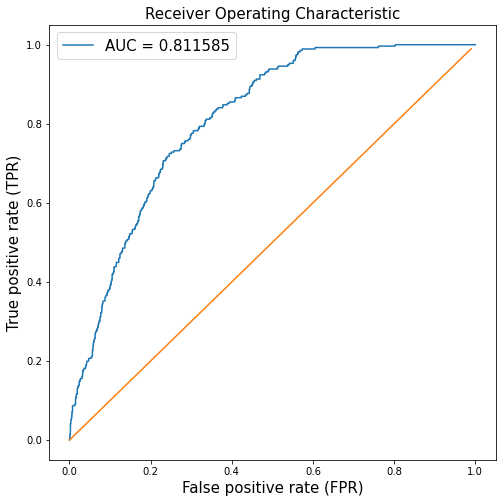

In [218]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## Decision Tree

Разделение датафрема на тренировочную и тестовую часть

In [219]:
train_tree = df[df['target'].isna() == False]
test_tree = df[df['target'].isna() == True]

In [220]:
X = train_tree.drop('target', axis=1)
y = train_tree['target']

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Создание модели

In [222]:
tree = DecisionTreeClassifier(random_state=121)

In [223]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=121)

In [224]:
print('Acuraccy on train sample for simple decision tree is: {}'.format(tree.score(X_train, y_train)))

Acuraccy on train sample for simple decision tree is: 0.9565352375038808


Оценка работы модели

In [225]:
y_pred = tree.predict(X_test)

In [226]:
y_pred_proba = tree.predict_proba(X_test)[:, 1]

In [227]:
f1_score(y_test, y_pred)

0.19343065693430656

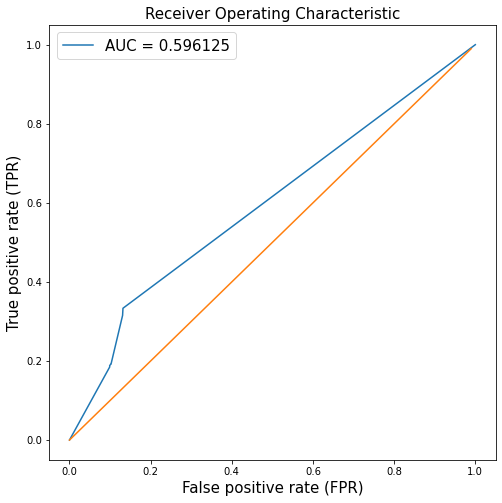

In [228]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## RandomForest

Разделение датафрема на тренировочную и тестовую часть

In [229]:
train_forest = df[df['target'].isna() == False]
test_forest = df[df['target'].isna() == True]

In [230]:
X = train_forest.drop('target', axis=1)
y = train_forest['target']

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Создание модели

In [232]:
forest = RandomForestClassifier(random_state=121)

In [233]:
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=121)

In [234]:
print('Acuraccy on train sample for simple decision tree is: {}'.format(forest.score(X_train, y_train)))

Acuraccy on train sample for simple decision tree is: 0.9565352375038808


Оценка работы модели

In [235]:
y_pred = forest.predict(X_test)

In [236]:
y_pred_proba = forest.predict_proba(X_test)[:, 1]

In [237]:
f1_score(y_test, y_pred)

0.19953596287703018

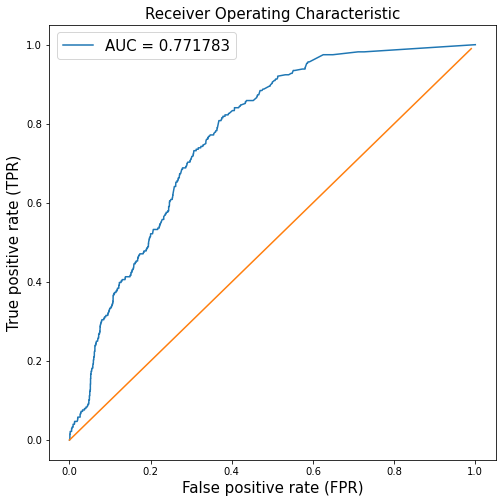

In [238]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## LGBMClassifier()

Создание копии датафрейма для дальнейших экспериментов

In [239]:
df_mean_knn = df.copy()

Разбиение данных на тренировочную и тестовую часть

In [240]:
train_lgbm = df[df['target'].isna() == False]
test_lgbm = df[df['target'].isna() == True]

## !

Для данной модели были заранее удалены некоторые мат. признаки, так как они ухудшали предсказательную способность на 0.3 

X = train_lgbm.drop(['target', 'insurance_duration', 'age+no_pol', 'age+insurance_duration',
                    'insurance_duration+no_pol', 'age*no_pol', 'age*insurance_duration',
                    'insurance_duration*no_pol'], axis=1)
y = train_lgbm['target']

In [241]:
X = train_lgbm.drop(['target',  'age+no_pol', 'age*no_pol'], axis=1)
y = train_lgbm['target']

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

Создание модели

In [243]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

Оценка работы модели

In [244]:
y_pred = model.predict(X_test)

In [245]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [246]:
th = 0.2
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

preds[proba>=th] = 1
preds[proba<th] = 0

f1_score(y_test,preds)

0.39999999999999997

In [247]:
f1_score(y_test, y_pred)

0.23129251700680273

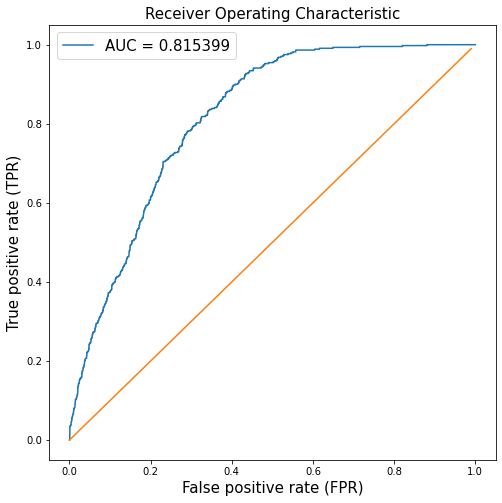

In [248]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## XGBoostClassifier

Разбиение данных на тренировочную и тестовую часть

In [249]:
train_xg = df[df['target'].isna() == False]
test_xg = df[df['target'].isna() == True]

In [250]:
X = train_xg.drop(['target'], axis=1)
y = train_xg['target']

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=21)

Создание модели

In [252]:
xgb = XGBClassifier()

In [253]:
xgb.fit(X_train, y_train)

[22:55:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Оценка работы модели

In [254]:
y_pred = xgb.predict(X_test)

In [255]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

In [256]:
f1_score(y_test, y_pred)

0.22042139384116693

In [257]:
th = 0.2
preds = xgb.predict(X_test)
proba = xgb.predict_proba(X_test)[:,1]

preds[proba>=th] = 1
preds[proba<th] = 0

f1_score(y_test,preds)

0.37735849056603776

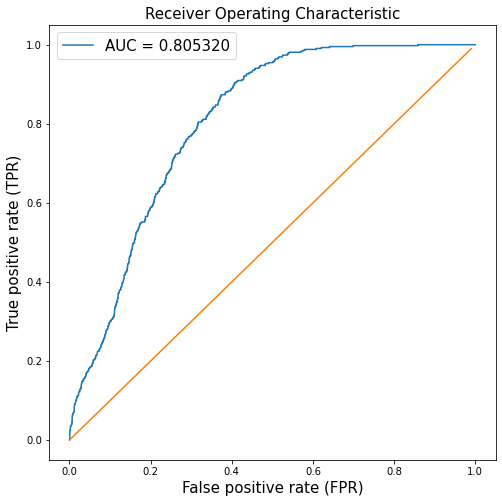

In [258]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

# Вывод:

По итогам эксперимента модель LGBMCLassifier показала наилучший, хоть и не высокий результат на данных, где пустые значения обработаны с помощью MeanTargetEnc.

_____________________

# Эксперимент 2

## Oбработка данных: KNN Imputer + get_dummies

In [259]:
df = dataframe.copy()

Следует првоести обработку временных признаков еще раз

In [260]:
df.drop('ftd', axis=1, inplace=True)

In [261]:
df['year_psd'] = df['psd'].apply(lambda x: x.year)
df['year_ped'] = df['ped'].apply(lambda x: x.year)
df['insurance_duration'] = df['year_ped'] - df['year_psd'] 
df['age+no_pol'] = df['age'] + df['no_pol']

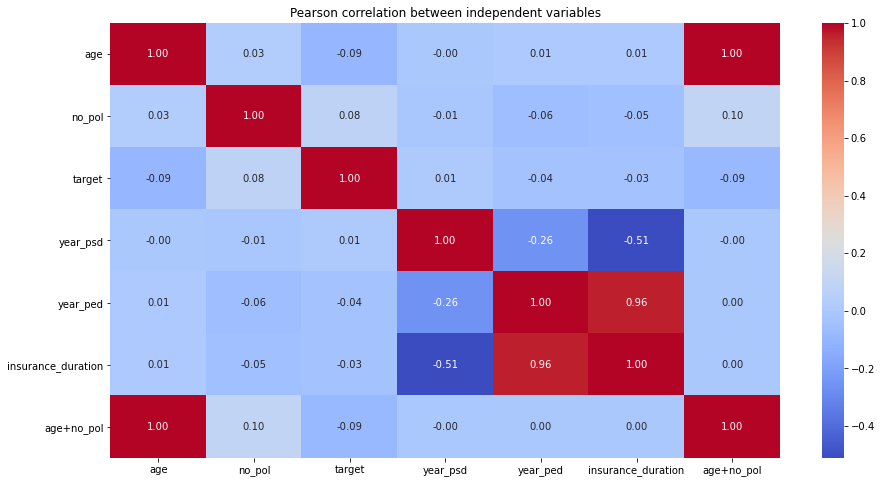

In [262]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Pearson correlation between independent variables')
plt.show()

In [263]:
df.head()

,psd,ped,gender,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,year_psd,year_ped,insurance_duration,age+no_pol
0,2010-05-14,2011-05-13,Male,30,1,Sedan,Black,TOYOTA,Kaduna North,Nnewi-North,Car Classic,0.0,2010,2011,1,31
1,2010-11-29,2011-11-28,Female,41,1,Sedan,Grey,TOYOTA,Oredo,Ibarapa-Central,Car Classic,1.0,2010,2011,1,42
2,2010-03-21,2011-03-20,Male,43,1,Sedan,Red,TOYOTA,Isoko south,Ile-Oluji,Car Classic,0.0,2010,2011,1,44
3,2010-08-21,2011-08-20,Male,41,1,Sedan,Dark Green,Nissan,Ogba/Egbema/Ndoni,Imo,CarSafe,0.0,2010,2011,1,42
4,2010-08-29,2010-12-31,Other,20,3,Sedan,As Attached,Jincheng,Lagos,Lagos,Muuve,1.0,2010,2010,0,23


Распределение данных тренировочные тестовые значения

In [264]:
test = df[df.target.isna()]
train = df[~df.target.isna()]

In [265]:
train.duplicated().sum()

840

In [266]:
train.drop_duplicates(inplace=True)

In [267]:
cat_features

['gender',
 'car_category',
 'subject_car_colour',
 'subject_car_make',
 'lga_name',
 'state',
 'product_name']

In [268]:
date_cols = ['psd', 'ped']

Использование Get Dummies

In [269]:
train = pd.get_dummies(data = train, columns = cat_features)

In [270]:
train.columns.duplicated().sum()

0

In [271]:
train.isna().sum().sum()

0

Коррекция названий колонок для более точной работы модели.

In [272]:
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [273]:
X = train.drop(['target']+date_cols, axis=1)
y = train['target']

In [274]:
len(X.columns)

495

In [275]:
X = get_cleaned_cols(X)

In [276]:
X.shape, y.shape

((11239, 493), (11239,))

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(iterations=50)

Так как в предыдущем эксперименте лучшей моделью оказалась LGBMClassifier, следует попробовать использовать ее здесь.

In [278]:
lgbm = LGBMClassifier()

In [279]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

sorted(zip(model.feature_importances_,model.feature_names_),key=lambda x:x[0], reverse=True)[:20]

In [280]:
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:, 1]


f1_score(y_test, y_pred)

0.07472527472527472

th = 0.2

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

#y_pred[y_pred >= th] = 1
#y_pred[y_pred < th] = 0
#
f1_score(y_test,y_pred)

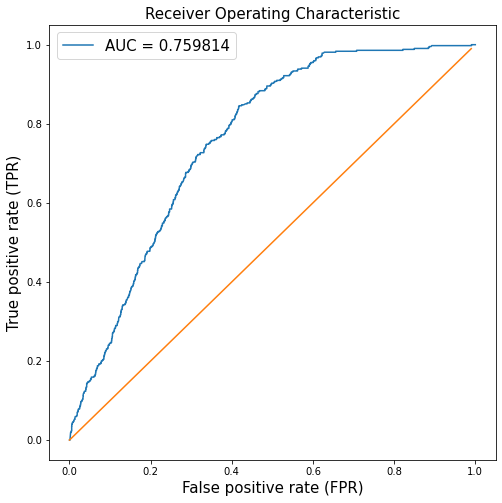

In [281]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## Вывод:

Данная обработка дала худший результат. 

_____________________

# Эксперимент 3

## Обработка данных: MODE + mean target enc


In [282]:
dataframe = data.copy()

In [283]:
cat_features

['gender',
 'car_category',
 'subject_car_colour',
 'subject_car_make',
 'lga_name',
 'state',
 'product_name']

In [284]:
col_cols = ['age', 'no_pol']

Заполнение пустых значений с помощью функции Mode ( наиболее часто встречаемое значение )

In [285]:
for elem in ['car_category', 'subject_car_colour', 'subject_car_make', 'lga_name', 'state']:
    dataframe[elem] = dataframe[elem].fillna(dataframe[elem].mode()[0])

In [286]:
dataframe.isna().sum()

psd                      0
ped                      0
gender                   0
age                      0
ftd                      0
no_pol                   0
car_category             0
subject_car_colour       0
subject_car_make         0
lga_name                 0
state                    0
product_name             0
target                1202
dtype: int64

Обработка данных

In [287]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [288]:
ohe_result = ohe.fit_transform(dataframe.loc[:, ['gender']]).toarray()

In [289]:
ohe_result

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [290]:
dataframe['female'] = ohe_result[:, 0]
dataframe['male'] = ohe_result[:, 1]
dataframe['other'] = ohe_result[:, 2]
dataframe.drop('gender', axis=1, inplace=True)

In [291]:
cat_feats = ['car_category', 'subject_car_colour', 'subject_car_make', 'lga_name', 'product_name']

In [292]:
get_mean_target_encoding(dataframe, 'state').head()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,female,male,other
0,2010-05-14,2011-05-13,30,2010-05-14,1,Sedan,Black,TOYOTA,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
1,2010-11-29,2011-11-28,41,2010-11-29,1,Sedan,Grey,TOYOTA,Victoria Island,0.10988,Car Classic,1.0,1.0,0.0,0.0
2,2010-03-21,2011-03-20,43,2010-03-21,1,Sedan,Red,TOYOTA,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
3,2010-08-21,2011-08-20,41,2010-08-21,1,Sedan,Black,TOYOTA,Victoria Island,0.10988,CarSafe,0.0,0.0,1.0,0.0
4,2010-08-29,2010-12-31,20,2010-08-29,3,Sedan,Black,TOYOTA,0.10988,0.10988,Muuve,1.0,0.0,0.0,1.0


In [293]:
get_mean_target_encoding(dataframe, 'car_category').head()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,female,male,other
0,2010-05-14,2011-05-13,30,2010-05-14,1,0.11611,Black,TOYOTA,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
1,2010-11-29,2011-11-28,41,2010-11-29,1,0.11611,Grey,TOYOTA,Victoria Island,0.10988,Car Classic,1.0,1.0,0.0,0.0
2,2010-03-21,2011-03-20,43,2010-03-21,1,0.11611,Red,TOYOTA,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
3,2010-08-21,2011-08-20,41,2010-08-21,1,0.11611,Black,TOYOTA,Victoria Island,0.10988,CarSafe,0.0,0.0,1.0,0.0
4,2010-08-29,2010-12-31,20,2010-08-29,3,0.11611,Black,TOYOTA,0.10988,0.10988,Muuve,1.0,0.0,0.0,1.0


In [294]:
get_mean_target_encoding(dataframe, 'subject_car_colour').head()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,female,male,other
0,2010-05-14,2011-05-13,30,2010-05-14,1,0.11611,0.08143,TOYOTA,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
1,2010-11-29,2011-11-28,41,2010-11-29,1,0.11611,0.24184,TOYOTA,Victoria Island,0.10988,Car Classic,1.0,1.0,0.0,0.0
2,2010-03-21,2011-03-20,43,2010-03-21,1,0.11611,0.23506,TOYOTA,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
3,2010-08-21,2011-08-20,41,2010-08-21,1,0.11611,0.08143,TOYOTA,Victoria Island,0.10988,CarSafe,0.0,0.0,1.0,0.0
4,2010-08-29,2010-12-31,20,2010-08-29,3,0.11611,0.08143,TOYOTA,0.10988,0.10988,Muuve,1.0,0.0,0.0,1.0


In [295]:
dataframe['subject_car_colour'].fillna(dataframe['subject_car_colour'].mode()[0], inplace=True)

In [296]:
get_mean_target_encoding(dataframe, 'subject_car_make').head()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,female,male,other
0,2010-05-14,2011-05-13,30,2010-05-14,1,0.11611,0.08143,0.12079,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
1,2010-11-29,2011-11-28,41,2010-11-29,1,0.11611,0.24184,0.12079,Victoria Island,0.10988,Car Classic,1.0,1.0,0.0,0.0
2,2010-03-21,2011-03-20,43,2010-03-21,1,0.11611,0.23506,0.12079,Victoria Island,0.10988,Car Classic,0.0,0.0,1.0,0.0
3,2010-08-21,2011-08-20,41,2010-08-21,1,0.11611,0.08143,0.12079,Victoria Island,0.10988,CarSafe,0.0,0.0,1.0,0.0
4,2010-08-29,2010-12-31,20,2010-08-29,3,0.11611,0.08143,0.12079,0.10988,0.10988,Muuve,1.0,0.0,0.0,1.0


In [297]:
get_mean_target_encoding(dataframe, 'lga_name').head()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,female,male,other
0,2010-05-14,2011-05-13,30.0,2010-05-14,1.0,0.11611,0.08143,0.12079,0.09623,0.29762,Car Classic,0.0,0.0,1.0,0.0
1,2010-11-29,2011-11-28,41.0,2010-11-29,1.0,0.11611,0.24184,0.12079,0.09623,0.29762,Car Classic,1.0,1.0,0.0,0.0
2,2010-03-21,2011-03-20,43.0,2010-03-21,1.0,0.11611,0.23506,0.12079,0.09623,0.29762,Car Classic,0.0,0.0,1.0,0.0
3,2010-08-21,2011-08-20,41.0,2010-08-21,1.0,0.11611,0.08143,0.12079,0.09623,0.29762,CarSafe,0.0,0.0,1.0,0.0
4,2010-08-29,2010-12-31,20.0,2010-08-29,3.0,0.11611,0.08143,0.12079,0.29762,0.29762,Muuve,1.0,0.0,0.0,1.0


In [298]:
get_mean_target_encoding(dataframe, 'product_name').head()

,psd,ped,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target,female,male,other
0,2010-05-14,2011-05-13,30.0,2010-05-14,1.0,0.11611,0.08143,0.12079,0.09623,0.29762,0.16561,0.0,0.0,1.0,0.0
1,2010-11-29,2011-11-28,41.0,2010-11-29,1.0,0.11611,0.24184,0.12079,0.09623,0.29762,0.16561,1.0,1.0,0.0,0.0
2,2010-03-21,2011-03-20,43.0,2010-03-21,1.0,0.11611,0.23506,0.12079,0.09623,0.29762,0.16561,0.0,0.0,1.0,0.0
3,2010-08-21,2011-08-20,41.0,2010-08-21,1.0,0.11611,0.08143,0.12079,0.09623,0.29762,0.00371,0.0,0.0,1.0,0.0
4,2010-08-29,2010-12-31,20.0,2010-08-29,3.0,0.11611,0.08143,0.12079,0.29762,0.29762,0.69892,1.0,0.0,0.0,1.0


In [299]:
dataframe['car_category'].fillna(dataframe['car_category'].mode()[0], inplace=True)
dataframe['state'].fillna(dataframe['state'].mode()[0], inplace=True)
dataframe['lga_name'].fillna(dataframe['lga_name'].mode()[0], inplace=True)
dataframe['subject_car_make'].fillna(dataframe['subject_car_make'].mode()[0], inplace=True)

In [300]:
dataframe.isna().sum()

psd                      0
ped                      0
age                      0
ftd                      0
no_pol                   0
car_category             0
subject_car_colour       0
subject_car_make         0
lga_name                 0
state                    0
product_name             0
target                1202
female                   0
male                     0
other                    0
dtype: int64

In [301]:
dataframe['year_psd'] = dataframe['psd'].apply(lambda x: x.year)
dataframe['year_ped'] = dataframe['ped'].apply(lambda x: x.year)
dataframe['insurance_duration'] = dataframe['year_ped'] - dataframe['year_psd'] 
dataframe['age+no_pol'] = dataframe['age'] + dataframe['no_pol']
# dataframe['age+insurance_duration'] = dataframe['age'] + dataframe['insurance_duration']
# dataframe['insurance_duration+no_pol'] = dataframe['insurance_duration'] + dataframe['no_pol']
dataframe['age*no_pol'] = dataframe['age'] * dataframe['no_pol']
# dataframe['age*insurance_duration'] = dataframe['insurance_duration'] * dataframe['age']
# dataframe['insurance_duration*no_pol'] = dataframe['insurance_duration'] * dataframe['no_pol']

Разделение на тренировочную и тестовую часть.

In [302]:
test = dataframe[dataframe['target'].isna()]
train = dataframe[~dataframe['target'].isna()]

In [303]:
X = train.drop(['target', 'ftd']+date_cols, axis=1)
y = train['target']

In [304]:
X.shape, y.shape

((12079, 16), (12079,))

In [305]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Создание модели

In [306]:
lgbm = LGBMClassifier()

In [307]:
X_train

,age,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,female,male,other,year_psd,year_ped,insurance_duration,age+no_pol,age*no_pol
2840,31.0,1.0,0.11611,0.27978,0.12079,0.09623,0.29762,0.16561,0.0,1.0,0.0,2010,2011,1,32.0,31.0
1613,50.0,2.0,0.11611,0.08143,0.12079,0.17073,0.17073,0.16561,0.0,1.0,0.0,2010,2011,1,52.0,100.0
6765,46.0,1.0,0.11611,0.08143,0.00000,0.09623,0.29762,0.00371,0.0,1.0,0.0,2010,2011,1,47.0,46.0
792,30.0,1.0,0.11611,0.21160,0.12079,0.16425,0.29762,0.16561,0.0,1.0,0.0,2010,2011,1,31.0,30.0
233,51.0,2.0,0.17391,0.08143,0.12079,0.09623,0.29762,0.17391,0.0,1.0,0.0,2010,2012,2,53.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,56.0,1.0,0.11611,0.08143,0.11708,0.09623,0.29762,0.00371,0.0,1.0,0.0,2010,2011,1,57.0,56.0
5191,41.0,1.0,0.11611,0.24184,0.12079,0.32143,0.29762,0.16561,0.0,1.0,0.0,2010,2011,1,42.0,41.0
5390,43.0,2.0,0.11611,0.08143,0.12079,0.22414,0.22414,0.16561,0.0,1.0,0.0,2010,2011,1,45.0,86.0
860,43.0,1.0,0.11611,0.24184,0.12079,0.09623,0.29762,0.21193,0.0,1.0,0.0,2010,2011,1,44.0,43.0


In [308]:
model = lgbm.fit(X_train, y_train)

In [309]:
th = 0.2

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

#y_pred[y_pred >= th] = 1
#y_pred[y_pred < th] = 0
#
f1_score(y_test,y_pred)

0.2328767123287671

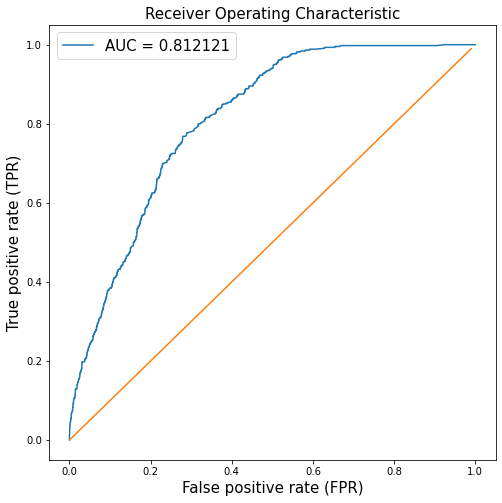

In [310]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## Вывод:

Обработка с помощью menatarget + Mode дала результат хуже, чем в первом, но лучше, чем во втором экспериментах. Использование MeanTargetEnc. начинает оправдывает себя

_____________

#  Эксперимент 4 
## обработка данных: MODE + get_dummies


Предлагается опробовать данную обработку на всех моделях

In [311]:
dataframe = data.copy()

In [312]:
dataframe.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve,1.0


In [313]:
cat_features

['gender',
 'car_category',
 'subject_car_colour',
 'subject_car_make',
 'lga_name',
 'state',
 'product_name']

In [314]:
col_cols = ['age', 'no_pol']

Заполнение пустых значений с помощью функции Mode ( наиболее часто встречаемое значение )

In [315]:
for elem in ['car_category', 'subject_car_colour', 'subject_car_make', 'lga_name', 'state']:
    dataframe[elem] = dataframe[elem].fillna(dataframe[elem].mode()[0])

In [316]:
dataframe.isna().sum()

psd                      0
ped                      0
gender                   0
age                      0
ftd                      0
no_pol                   0
car_category             0
subject_car_colour       0
subject_car_make         0
lga_name                 0
state                    0
product_name             0
target                1202
dtype: int64

Разделение на тренировочную и тестовую часть

In [317]:
test = dataframe[dataframe['target'].isna()]
train = dataframe[~dataframe['target'].isna()]

Использование Get Dummies

In [318]:
train = pd.get_dummies(data = train, columns = cat_features)

In [319]:
train['year_psd'] = train['psd'].apply(lambda x: x.year)
train['year_ped'] = train['ped'].apply(lambda x: x.year)
train['insurance_duration'] = train['year_ped'] - train['year_psd'] 
train['age+no_pol'] = train['age'] + train['no_pol']
#train['age+insurance_duration'] = train['age'] + train['insurance_duration']
#train['insurance_duration+no_pol'] = train['insurance_duration'] + train['no_pol']
train['age*no_pol'] = train['age'] * train['no_pol']
#train['age*insurance_duration'] = train['insurance_duration'] * train['age']
#train['insurance_duration*no_pol'] = train['insurance_duration'] * train['no_pol']

In [320]:
train.columns.duplicated().sum()

0

In [321]:
train.isna().sum().sum()

0

In [322]:
train_mode_dumm = train.copy()

In [323]:
X = train.drop(['target']+date_cols, axis=1)
y = train['target']

In [324]:
X.shape, y.shape

((12079, 488), (12079,))

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Создание модели

In [326]:
model = CatBoostClassifier(iterations=50)

In [327]:
model.fit(X_train,y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.399812
0:	learn: 0.4021240	total: 5.78ms	remaining: 283ms
1:	learn: 0.3397537	total: 11.1ms	remaining: 266ms
2:	learn: 0.3176597	total: 16.7ms	remaining: 261ms
3:	learn: 0.3093669	total: 22.1ms	remaining: 254ms
4:	learn: 0.3065271	total: 28ms	remaining: 252ms
5:	learn: 0.3002909	total: 33.2ms	remaining: 243ms
6:	learn: 0.2945212	total: 38.4ms	remaining: 236ms
7:	learn: 0.2920161	total: 43.7ms	remaining: 230ms
8:	learn: 0.2907165	total: 49.1ms	remaining: 224ms
9:	learn: 0.2900941	total: 54.4ms	remaining: 218ms
10:	learn: 0.2878174	total: 60.1ms	remaining: 213ms
11:	learn: 0.2863294	total: 65.3ms	remaining: 207ms
12:	learn: 0.2859373	total: 70.5ms	remaining: 201ms
13:	learn: 0.2852872	total: 76.8ms	remaining: 198ms
14:	learn: 0.2839969	total: 82.6ms	remaining: 193ms
15:	learn: 0.2835264	total: 88ms	remaining: 187ms
16:	learn: 0.2825602	total: 93.3ms	remaining: 181ms
17:	learn: 0.2817920	total: 98.8ms	remaining: 176ms
18:	learn: 0.2811037	total: 104ms	remaining: 170

In [328]:
sorted(zip(model.feature_importances_,model.feature_names_),key=lambda x:x[0], reverse=True)[:20]

[(57.41353986009856, 'product_name_CarSafe'),
 (8.626144633735219, 'ftd'),
 (7.0231847199373805, 'age*no_pol'),
 (3.4743525088656915, 'age+no_pol'),
 (3.2832744554511355, 'product_name_Customized Motor'),
 (2.557451726712155, 'age'),
 (1.845663005569372, 'subject_car_colour_Black'),
 (1.3346928506420064, 'subject_car_make_TOYOTA'),
 (0.991176353970339, 'product_name_Muuve'),
 (0.9264910517791374, 'no_pol'),
 (0.6705504417018278, 'state_Abuja-Municipal'),
 (0.6387733040088274, 'lga_name_Victoria Island'),
 (0.6008402649029078, 'gender_Male'),
 (0.5331168120437537, 'lga_name_Kosofe'),
 (0.45180841950169204, 'gender_Other'),
 (0.3957640721987935, 'product_name_CVTP'),
 (0.39540287324021056, 'subject_car_colour_Blue'),
 (0.33630533334451296, 'gender_Female'),
 (0.33367996400153305, 'product_name_Car Plus'),
 (0.3240520371931087, 'subject_car_make_Land Rover')]

In [329]:
th = 0.2

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

#y_pred[y_pred >= th] = 1
#y_pred[y_pred < th] = 0

f1_score(y_test,y_pred)

0.1814946619217082

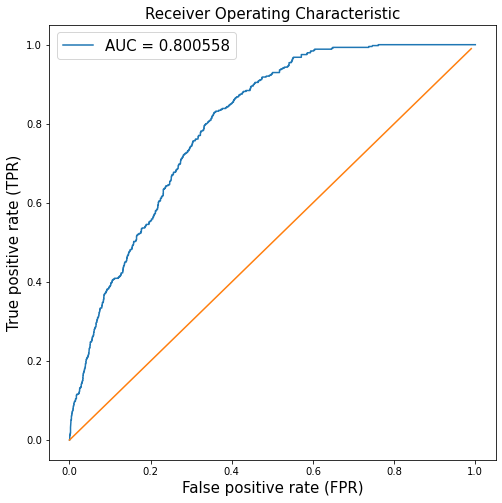

In [330]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

Подготовка датафрейма для остальных моделей

In [331]:
final_df = data.copy()

In [332]:
final_df.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve,1.0


In [333]:
(final_df['ped'] - final_df['psd'])[0].days

364

In [334]:
final_df['year_psd'] = final_df['psd'].apply(lambda x: x.year)
final_df['year_ped'] = final_df['ped'].apply(lambda x: x.year)
final_df['f_m'] = final_df['psd'].apply(lambda x: x.month)
final_df['f_d'] = final_df['psd'].apply(lambda x: x.day)

In [335]:
final_df['year_psd'] = final_df['psd'].apply(lambda x: x.year)
final_df['year_ped'] = final_df['ped'].apply(lambda x: x.year)
final_df['insurance_duration'] = final_df['year_ped'] - final_df['year_psd'] 
final_df['age+no_pol'] = final_df['age'] + final_df['no_pol']
#final_df['age+insurance_duration'] = final_df['age'] + final_df['insurance_duration']
#final_df['insurance_duration+no_pol'] = final_df['insurance_duration'] + final_df['no_pol']
final_df['age*no_pol'] = final_df['age'] * final_df['no_pol']
#final_df['age*insurance_duration'] = final_df['insurance_duration'] * final_df['age']
#final_df['insurance_duration*no_pol'] = final_df['insurance_duration'] * final_df['no_pol']

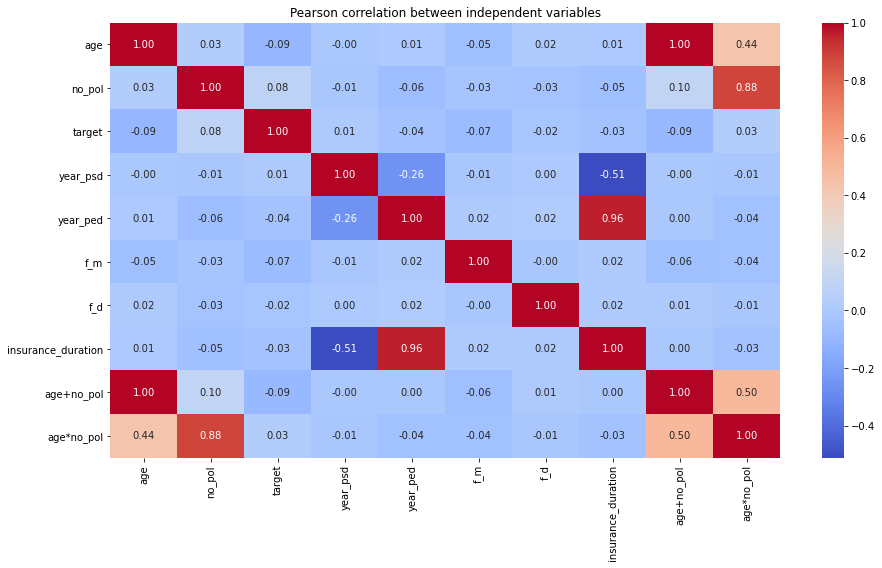

In [336]:
correlation_mat = final_df.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Pearson correlation between independent variables')
plt.show()

In [337]:
final_df['gender_mean'] = final_df['gender'].replace(final_df.groupby(['gender']).mean()['age'].to_dict())

In [338]:
final_df['gender_std'] = final_df['gender'].replace(final_df.groupby(['gender']).std()['age'].to_dict())

In [339]:
print(final_df['age'].sort_values().unique())

[19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69]


In [340]:
final_df['age_marked'] = get_age_mark(final_df, 'age')

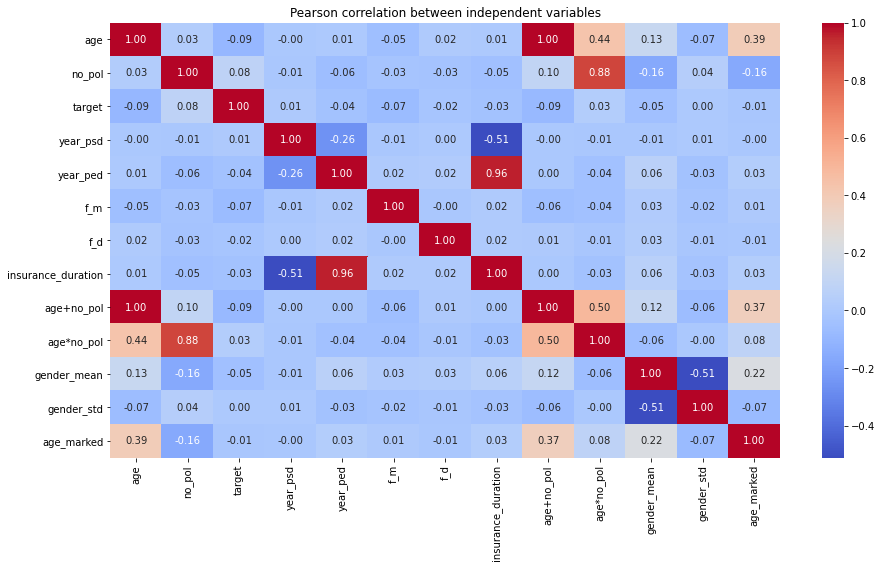

In [341]:
correlation_mat = final_df.corr()
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_mat, cmap='coolwarm', annot=True, fmt=".2f").set_title('Pearson correlation between independent variables')
plt.show()

In [342]:
for elem in ['car_category', 'subject_car_colour', 'subject_car_make', 'lga_name', 'state']:
    final_df[elem] = final_df[elem].fillna(final_df[elem].mode()[0])

final_df.isna().sum()

psd                      0
ped                      0
gender                   0
age                      0
ftd                      0
no_pol                   0
car_category             0
subject_car_colour       0
subject_car_make         0
lga_name                 0
state                    0
product_name             0
target                1202
year_psd                 0
year_ped                 0
f_m                      0
f_d                      0
insurance_duration       0
age+no_pol               0
age*no_pol               0
gender_mean              0
gender_std               0
age_marked               0
dtype: int64

## Decision Tree

Разбиение данных на тренировочную и тестовую части

In [343]:
train_tree = final_df[final_df['target'].isna() == False]
test_tree = final_df[final_df['target'].isna() == True]

Использование Get Dummies

In [344]:
train_tree = pd.get_dummies(data = train_tree, columns = cat_features)

In [345]:
X = train_tree.drop(['target', 'ftd', 'psd', 'ped'], axis=1)
y = train_tree['target']

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Построение модели

In [347]:
tree = DecisionTreeClassifier(random_state=121)

In [348]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=121)

In [349]:
print('Acuraccy on train sample for simple decision tree is: {}'.format(tree.score(X_train, y_train)))

Acuraccy on train sample for simple decision tree is: 0.9563282624443754


Оценка модели

In [350]:
y_pred = tree.predict(X_test)

In [351]:
y_pred_proba = tree.predict_proba(X_test)[:, 1]

In [352]:
f1_score(y_test, y_pred)

0.1702127659574468

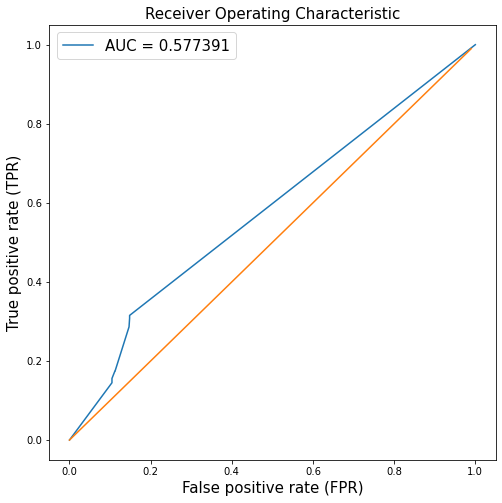

In [353]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## RandomForest

Разбиение данных на тренировочную и тестовую части

In [354]:
train_forest = final_df[final_df['target'].isna() == False]
test_forest = final_df[final_df['target'].isna() == True]

Использование Get Dummies

In [355]:
train_forest = pd.get_dummies(data = train_forest, columns = cat_features)

In [356]:
X = train_forest.drop(['target', 'ftd', 'psd', 'ped'], axis=1)
y = train_forest['target']

In [357]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Построение модели

In [358]:
forest = RandomForestClassifier(random_state=121)

In [359]:
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=121)

In [360]:
print('Acuraccy on train sample for simple decision tree is: {}'.format(forest.score(X_train, y_train)))

Acuraccy on train sample for simple decision tree is: 0.9563282624443754


Оценка модели

In [361]:
y_pred = forest.predict(X_test)

In [362]:
y_pred_proba = forest.predict_proba(X_test)[:, 1]

In [363]:
f1_score(y_test, y_pred)

0.1839080459770115

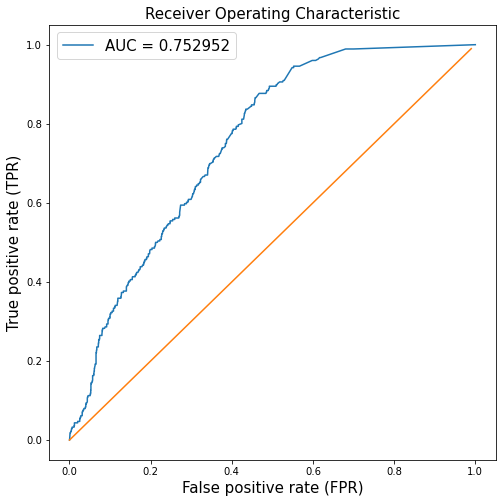

In [364]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## LGBMClassifier()

Разбиение данных на тренировочную и тестовую части

In [365]:
train_lgbm = final_df[final_df['target'].isna() == False]
test_lgbm = final_df[final_df['target'].isna() == True]

Использование Get Dummies

In [366]:
train_lgbm = pd.get_dummies(data = train_lgbm, columns = cat_features)

Очистка названия колонок от лишних значений для лучшей работы модели LGBMClassifier

In [367]:
train_lgbm = train_lgbm.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [368]:
X = train_lgbm.drop(['target', 'ftd', 'psd', 'ped'], axis=1)
y = train_lgbm['target']

In [369]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Построение модели

In [370]:
lg = LGBMClassifier(Random_state=121)

In [371]:
lg.fit(X_train, y_train)

LGBMClassifier(Random_state=121)

In [372]:
print('Acuraccy on train sample for simple decision tree is: {}'.format(lg.score(X_train, y_train)))

Acuraccy on train sample for simple decision tree is: 0.8983752457828832


Оценка модели

In [373]:
y_pred = lg.predict(X_test)

In [374]:
y_pred_proba = lg.predict_proba(X_test)[:, 1]

In [375]:
f1_score(y_test, y_pred)

0.1510574018126888

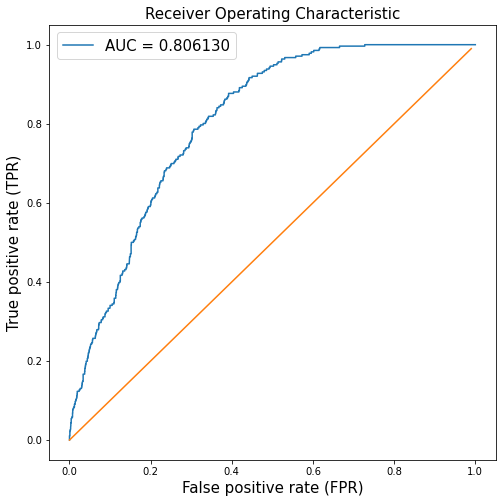

In [376]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## XGBoostClassifier

Разбиение данных на тренировочную и тестовую части

In [377]:
train_xg = final_df[final_df['target'].isna() == False]
test_xg = final_df[final_df['target'].isna() == True]

Использование Get Dummies

In [378]:
train_xg = pd.get_dummies(data = train_xg, columns = cat_features)

In [379]:
X = train_xg.drop(['target', 'psd','ped', 'ftd'], axis=1)
y = train_xg['target']

In [380]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

Построение модели

In [381]:
xgb = XGBClassifier()

In [382]:
xgb.fit(X_train, y_train)

[22:55:46] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

    XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                  colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                  importance_type='gain', interaction_constraints='',
                  learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                  min_child_weight=1, missing=nan, monotone_constraints='()',
                  n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                  tree_method='exact', validate_parameters=1, verbosity=None)

Оценка модели

In [383]:
y_pred = xgb.predict(X_test)

In [384]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

In [385]:
f1_score(y_test, y_pred)

0.18941504178272983

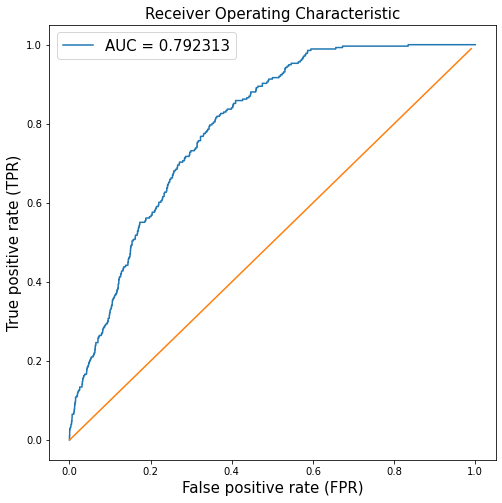

In [386]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

## Результат эксперимента

Лучшей обработкой оказалось обработка пустых значений с помощью KNN и замена имеющихся значений на их среднюю по отношению к целевой переменной. Лучшей моделью оказалось XGBoost. Предлагается првоести кросс валидацию с целью улучшения результатов данной модели.

## Восстановление лучшего результата

## LGBMClassifier()

Разбиение данных на тренировочную и тестовую часть

In [387]:
train_lgbm = df_mean_knn[df_mean_knn['target'].isna() == False]
test_lgbm = df_mean_knn[df_mean_knn['target'].isna() == True]

## !

Для данной модели были заранее удалены некоторые мат. признаки, так как они ухудшали предсказательную способность на 0.3 

X = train_lgbm.drop(['target', 'insurance_duration', 'age+no_pol', 'age+insurance_duration',
                    'insurance_duration+no_pol', 'age*no_pol', 'age*insurance_duration',
                    'insurance_duration*no_pol'], axis=1)
y = train_lgbm['target']

In [388]:
X = train_lgbm.drop(['target', 'age+no_pol', 'age*no_pol'], axis=1)
y = train_lgbm['target']

In [389]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

Создание модели

In [390]:
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

Оценка работы модели

In [391]:
y_pred = model.predict(X_test)

In [392]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [393]:
th = 0.2
preds = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

preds[proba>=th] = 1
preds[proba<th] = 0

f1_score(y_test,preds)

0.39999999999999997

In [394]:
f1_score(y_test, y_pred)

0.23129251700680273

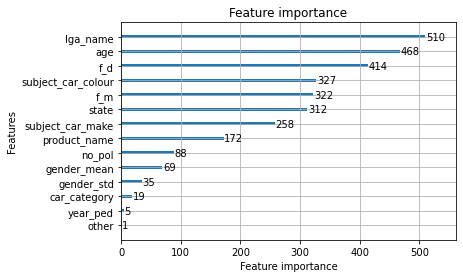

In [395]:
lgb.plot_importance(model);

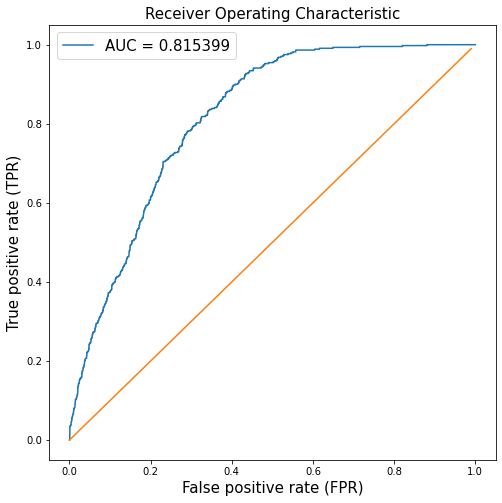

In [396]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

_______________

# Кросс Валидация

Разбиение на тренировочную и тестовую части

In [397]:
train_lgbm = df_mean_knn[df_mean_knn['target'].isna() == False]
test_lgbm = df_mean_knn[df_mean_knn['target'].isna() == True]

In [398]:
df_mean_knn.shape, data.shape

((13281, 21), (13281, 13))

In [399]:
X = train_lgbm.drop(['target', 'age+no_pol', 'age*no_pol'], axis=1)
y = train_lgbm['target']

задание параметров

In [400]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

gridParams = {
    'learning_rate': [0.005, 0.01, 0.02, 0.1],
    'n_estimators': [20, 40, 60],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

In [401]:
mdl = LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# To view the default model params:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq', 'max_bin', 'scale_pos_weight'])

Создание сетки

    grid = GridSearchCV(mdl, gridParams,
                        verbose=0,
                        cv=4,
                        n_jobs=2)

    grid.fit(X, y)

Оценка результата

    print(grid.best_params_)
    print(grid.best_score_)

    {'boosting_type': 'gbdt', 'colsample_bytree': 0.65, 'learning_rate': 0.1, 'n_estimators': 60, 'num_leaves': 16, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1.2, 'reg_lambda': 1, 'subsample': 0.7}
    0.8837653744825816

Построение модели с лучшими параметрами

In [402]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
model = LGBMClassifier(boosting_type = 'gbdt', colsample_bytree = 0.65, 
                       learning_rate = 0.1, 
                       n_estimators = 60, 
                       num_leaves = 16,
                       objective = 'binary', 
                       random_state = 501, 
                       reg_alpha = 1.2,
                       reg_lambda = 1,
                       subsample = 0.7)


In [403]:
model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.65, n_estimators=60, num_leaves=16,
               objective='binary', random_state=501, reg_alpha=1.2,
               reg_lambda=1, subsample=0.7)

Оценка модели

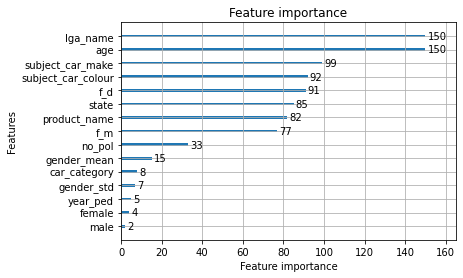

In [404]:
lgb.plot_importance(model);

In [405]:
y_pred = model.predict(X_test)

In [406]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [407]:
f1_score(y_test, y_pred)

0.15841584158415842

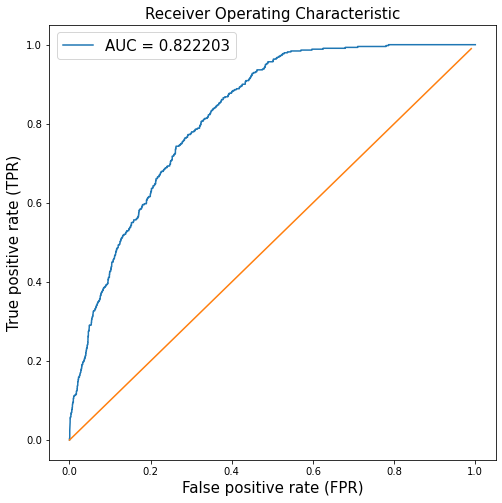

In [408]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba);
roc_auc = roc_auc_score(y_test, y_pred_proba);

plt.figure(figsize=(8, 8));

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.6f}');
plt.title('Receiver Operating Characteristic', fontsize=15);
plt.xlabel('False positive rate (FPR)', fontsize=15);
plt.ylabel('True positive rate (TPR)', fontsize=15);
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
plt.legend(fontsize=15);

plt.show()

# Вывод:

Модель без настройки параметров показала троекратно лучший результат. Предалается оставить базовые параметры

_______________

## Стороннее решение

Данное решение было взято из ноутбука на Kaggle. В нем предлагается решить задачу с помощью AutoML

Запуск библиотек

In [409]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

In [410]:
from tqdm.notebook import tqdm_notebook
from lightgbm import LGBMClassifier

In [411]:
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('binary', metric = f1_metric)

In [412]:
data.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve,1.0


Разбиение данных на тренировочную и тестовую части

In [413]:
test = data[data['target'].isna()]
train = data[~data['target'].isna()]

In [414]:
train.shape, test.shape

((12079, 13), (1202, 13))

In [415]:
train.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve,1.0


In [416]:
test.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
12079,2010-10-23,2011-10-22,Female,46,2010-10-23,1,None,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic,NaN
12080,2010-10-14,2011-10-13,Male,32,2010-10-14,1,None,NaN,NaN,Kosofe,Benue,Car Classic,NaN
12081,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Sedan,Black,Honda,Wuse 11,Abuja,Car Classic,NaN
12082,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Sedan,NaN,TOYOTA,NaN,NaN,CarSafe,NaN
12083,2010-07-01,2011-06-30,Other,41,2010-07-01,1,Sedan,Red,Hyundai,Victoria Island,Lagos,Car Classic,NaN


In [417]:
X = train.drop('target', axis=1)
y = train['target']

In [418]:
X.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve


In [419]:
X.shape, y.shape

((12079, 12), (12079,))

In [420]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.3 # Test size for metric check
TIMEOUT = 3600 

roles = {
    'target': 'target',
    'drop': ['psd', 'PolicypedStart Date', 'ftd'],
}

Создание и обучение модели

In [421]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = 600,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(train, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42}
Found general_params in kwargs, need to combine
Merged variant for general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']], 'return_all_predictions': False}
Start automl preset with listed constraints:
- time: 599.9979991912842 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (12079, 13)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 586.6162292957306 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.0
Linear model: C = 5e-05 score = 0.0
Linear model: C = 0.0001 score = 0.0

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.0
Line

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.293875	valid's Opt metric: 0.0721311
[200]	valid's binary_logloss: 0.277545	valid's Opt metric: 0.131661
[300]	valid's binary_logloss: 0.27281	valid's Opt metric: 0.162162
[400]	valid's binary_logloss: 0.272546	valid's Opt metric: 0.173134
[500]	valid's binary_logloss: 0.274163	valid's Opt metric: 0.188235
Early stopping, best iteration is:
[383]	valid's binary_logloss: 0.272172	valid's Opt metric: 0.173134
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.2947	valid's Opt metric: 0.0909091
[200]	valid's binary_logloss: 0.278676	valid's Opt metric: 0.141538
[

Оценка модели

In [422]:
test_pred = automl.predict(test)

In [423]:
test_pred = automl.predict(test.drop('target', axis=1))


print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))
print('OOF score: {}'.format(acc_score(train['target'].values, oof_pred.data)))

print('Check scores...')
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(train['target'].values, oof_pred.data)))

Prediction for test data:
array([[0.05978592],
       [0.02567852],
       [0.0281495 ],
       [0.0062425 ],
       [0.16623066],
       [0.05173758],
       [0.17505284],
       [0.24861366],
       [0.09925591],
       [0.06084896]], dtype=float32)
Shape = (1202, 1)
OOF score: 0.8846758837652123
Check scores...
Prediction for test data:
array([[0.05978592],
       [0.02567852],
       [0.0281495 ],
       [0.0062425 ],
       [0.16623066],
       [0.05173758],
       [0.17505284],
       [0.24861366],
       [0.09925591],
       [0.06084896]], dtype=float32)
Shape = (1202, 1)
Check scores...
OOF score: 0.8846758837652123


    Prediction for test data:
    array([[0.05978592],
           [0.02567852],
           [0.0281495 ],
           [0.0062425 ],
           [0.16623066],
           [0.05173758],
           [0.17505284],
           [0.24861366],
           [0.09925591],
           [0.06084896]], dtype=float32)
    Shape = (1202, 1)
    OOF score: 0.8846758837652123
    Check scores...
    Prediction for test data:
    array([[0.05978592],
           [0.02567852],
           [0.0281495 ],
           [0.0062425 ],
           [0.16623066],
           [0.05173758],
           [0.17505284],
           [0.24861366],
           [0.09925591],
           [0.06084896]], dtype=float32)
    Shape = (1202, 1)
    Check scores...
    OOF score: 0.8846758837652123

In [424]:
(test_pred.data[:, 0] > 0.5).astype(int).shape

(1202,)

Загрузка данных на соревнование

In [425]:
sub = pd.read_csv(r"C:\Users\79165\Desktop\SampleSubmission.csv")
sub["target"] = (test_pred.data[:, 0] > 0.5).astype(int)
sub.to_csv("submission.csv",index=False)

 ____________

In [426]:
data.head()

,psd,ped,gender,age,ftd,no_pol,car_category,subject_car_colour,subject_car_make,lga_name,state,product_name,target
0,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Sedan,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,2010-11-29,2011-11-28,Female,41,2010-11-29,1,Sedan,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Sedan,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,2010-08-21,2011-08-20,Male,41,2010-08-21,1,Sedan,NaN,NaN,NaN,NaN,CarSafe,0.0
4,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Sedan,NaN,NaN,Lagos,Lagos,Muuve,1.0


# Итоговый Вывод

Лучшую оценку дала модель AutoML

0.186046.
Другие модели показали немного худший результат на соревновании.


Безусловно, этого недостаточно, однако с учетом проделанной работы и опробованных методов следует сделать вывод, что данные являются нерепрезантативными- При построении модели и решении задачи нельзя исключать эмпирические знания, связанные с объектом исследования при сборе данных.

Основная цель состояла в урегулирование страховых исков и того, подаст ли клиент заявку на страхование транспортного средства в ближайшие три месяца. 

Из полезных признаков изначально имелось:
Начало и конец страховки, пол, возраст и тип автомобиля. Остальные данные не несут в себе большой пользы. 

Для более точного решения задачи необходимо собрать следующие данные:
- доход (личный)
- доход (семейный)
- состояние в браке
- число людей в семье
- наличие детей
- кредитная история
- длительность работы
- финансовая история клиента (здесь будет полезна любая информация)
- **стаж вождения** (одна из обязательных и ключевых метрик, странно, что она отсутствовала).
